In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os

import sys
sys.path.append('/Users/sbecker/Projects/RL_reward_novelty/') 

import models.snov.gabor_stimuli as gs
import models.snov.run_gabor_knov2 as gknov2
import models.snov.kernel_nov_vec as knov_vec
import fitting_neural.create_homann_input as h_in

import utils.saveload as sl
import utils.visualization as vis
import fitting_neural.simulate_data as sd

In [2]:
def cosine_sim(a,b):
    return np.dot(a.flatten(),b.flatten()) / (np.linalg.norm(a.flatten()) * np.linalg.norm(b.flatten()))

def orientation_sim_pergabor(a,b):
    return np.cos(a.flatten()-b.flatten())

def orientation_sim(a,b):
    return np.mean(np.heaviside(0.25*np.pi-np.abs(a.flatten()-b.flatten())%(2*np.pi),0))

def orientation_phase_sim(a,b): # num_samples x 2 (orientation, phase)
    return np.mean([np.mean(np.cos(a[0,:].flatten()-b[0,:].flatten())),np.mean(np.abs(a[1,:].flatten()-b[1,:].flatten()))])

In [3]:
# Compute kernel activation matrix
def compute_kernel_matrix(stim,k_params,idx=True,conv=True,parallel_k=False):   
    ksig0 = k_params['ksig']   
    k = k_params['k']
    if idx:
        stim_unique = stim[0]
        stim_idx    = stim[1]
    else:
        stim_unique = stim
        stim_idx    = list(np.arange(stim.shape[0]))
    # Initialize novelty
    if conv:
        cdens = k_params['cdens']
        num_conv = stim_unique[0,::cdens,::cdens].size
        knum = len(k) * num_conv
        kwl, kmat, kmat_seq, _, _, _ = knov_vec.init_nov_conv(k,ksig0,num_conv,seq=stim_unique,parallel=parallel_k)
    else:
        knum = len(k)
        kwl, kmat, kmat_seq, _, _, _ = knov_vec.init_nov(k,ksig0,seq=stim_unique,parallel=parallel_k)
    return kmat_seq


In [4]:
# Compute parent-child similarity
def comp_parent_sim(parent,list_children,sim_meas='cosine_sim'):
    parent_sim = []
    for i in range(len(list_children)):
        parent_sim.append(eval(sim_meas)(parent.flatten(),list_children[i].flatten()))
    return parent_sim

# Compute pairwise similarity
def comp_pairwise_sim(list_children,sim_meas='cosine_sim'):
    pairwise_sim = np.ones((len(list_children),len(list_children)))
    for i in range(len(list_children)):
        for j in range(i+1,len(list_children)):
            sim_ij = eval(sim_meas)(list_children[i].flatten(),list_children[j].flatten())
            pairwise_sim[i][j] = sim_ij
            pairwise_sim[j][i] = sim_ij
    return pairwise_sim

def plot_parent_sim(parent_sim,f,ax):
    # Plot parent and pairwise similarity
    bars = ax.bar(np.arange(len(parent_sim)),parent_sim,color='grey')
    # a_mu = ax[0].axhline(np.mean(parent_sim),color='black',linestyle='--')
    ax.set_title('Parent-child similarity')
    ax.set_xlabel('Child stimulus')
    ax.set_ylabel('Similarity')
    ax.set_ylim([np.max([0,np.min(parent_sim)-0.1]),np.min([1,np.max(parent_sim)+0.1])])
    ax.bar_label(bars,fmt='%.2f')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([f'Mean={np.round(np.mean(parent_sim),2)}'],loc='upper right')

def plot_pairwise_sim_matrix(pairwise_sim,f,ax):
    asim = ax.imshow(pairwise_sim,cmap='bwr',norm=colors.CenteredNorm(vcenter=np.mean(pairwise_sim.flatten())))    
    for i in range(pairwise_sim.shape[0]):
        for j in range(pairwise_sim.shape[1]):
            ax.text(j, i, np.round(pairwise_sim[i, j],2), ha="center", va="center", color="k")
    ax.set_title('Pairwise similarity of children')
    ax.set_xticks(np.arange(pairwise_sim.shape[0]))
    ax.set_yticks(np.arange(pairwise_sim.shape[1]))
    f.colorbar(asim, ax=ax,shrink=0.7)

def plot_pairwise_sim_hist(all_sim,f,ax,title='Pairwise similarity distribution',xlabel='Similarity'):
    ax.hist(all_sim,bins=30,color='grey',alpha=1)
    ylim = ax.get_ylim()
    mu = np.mean(all_sim)
    sigma = np.std(all_sim)
    a_mu = ax.axvline(mu,color='black',linestyle='--')
    a_sigma = ax.fill_between([mu-sigma,mu+sigma],[0]*2,[ylim[1]+0.1]*2,color='black',alpha=0.2)
    ax.set_ylim(ylim)    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([a_mu,a_sigma],[f'Mean={np.round(mu,2)}',f'Std={np.round(sigma,2)}'],loc='upper right')

def plot_sim(parent_sim, pairwise_sim):

    f,ax = plt.subplots(1,3,figsize=(20,6))

    # Plot parent and pairwise similarity
    plot_parent_sim(parent_sim,f,ax[0])

    # Plot pairwise similarity
    plot_pairwise_sim_matrix(pairwise_sim,f,ax[1])

    # Plot pairwise similarity histogram
    all_sim = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
    plot_pairwise_sim_hist(all_sim,f,ax[2])

    f.tight_layout()


# Toy experiment (old version)

## Create Gabor model (simple cells)

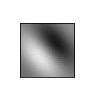

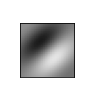

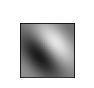

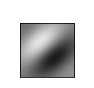

In [2]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)

In [3]:
k_params['ref_gabors']

orientation     phase  frequency     width  x-position  y-position
0     0.714197 -1.570796       0.04  8.333333         0.0         0.0
1     2.284994 -1.570796       0.04  8.333333         0.0         0.0
2     0.714197  1.570796       0.04  8.333333         0.0         0.0
3     2.284994  1.570796       0.04  8.333333         0.0         0.0

## Create toy experiment 

In [32]:
# Create Gabor images for toy experiment (3 familiar, 3 different novel)
orientations = np.array([[0, 0], [0, 0.5], [0, 0.5], [0.25, 0.25], [0, 0], [0, 0]])*np.pi
phases = np.array([[-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [0.5, -0.5], [-0.5, -0.5]])*np.pi
loc_idx = np.array([[0, 1], [0, 2], [1, 2], [0, 1], [0, 1], [1, 2]])
widths = np.array([[8.3, 8.3]*6])
frequencies = np.array([[0.04, 0.04]*6])

# Convert loc_idx into x-y coordinates
loc_to_xy = {0: [-50,40], 1: [50,40], 2: [-50,0], 3: [50,0]}
loc_x = np.array([[loc_to_xy[j][0] for j in loc_idx[i]] for i in range(len(loc_idx))])
loc_y = np.array([[loc_to_xy[j][1] for j in loc_idx[i]] for i in range(len(loc_idx))])

# Create dataframe
kcl_df = pd.DataFrame(dict(zip(gs.dim_names,[orientations.flatten(),phases.flatten(),frequencies.flatten(),widths.flatten(),loc_x.flatten(),loc_y.flatten()])))
kcl = kcl_df.to_numpy().transpose()

In [33]:
kcl_df

orientation     phase  frequency  width  x-position  y-position
0      0.000000 -1.570796       0.04    8.3         -50          40
1      0.000000 -1.570796       0.04    8.3          50          40
2      0.000000 -1.570796       0.04    8.3         -50          40
3      1.570796 -1.570796       0.04    8.3         -50           0
4      0.000000 -1.570796       0.04    8.3          50          40
5      1.570796 -1.570796       0.04    8.3         -50           0
6      0.785398 -1.570796       0.04    8.3         -50          40
7      0.785398 -1.570796       0.04    8.3          50          40
8      0.000000  1.570796       0.04    8.3         -50          40
9      0.000000 -1.570796       0.04    8.3          50          40
10     0.000000 -1.570796       0.04    8.3          50          40
11     0.000000 -1.570796       0.04    8.3         -50           0

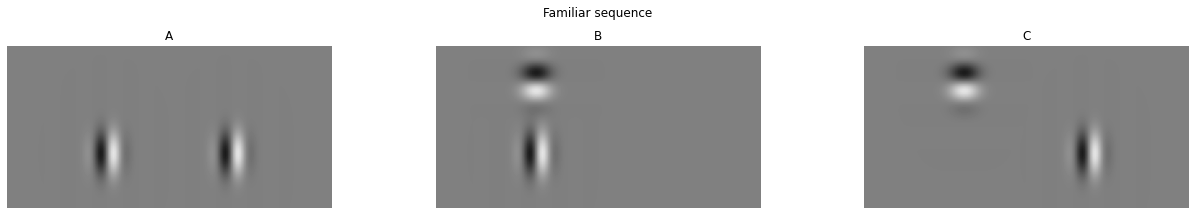

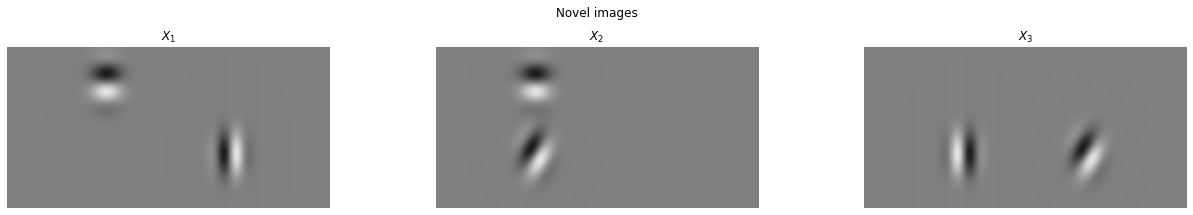

In [48]:
num_gabor = 2 
num_fam = 3
num_nov = 3

# Plot familiar Gabor images
f,ax = plt.subplots(1,num_fam,figsize=(num_fam*6,3))
titles = ['A','B','C']
gi_fam = []
for i in range(num_fam):
    gi,_ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],kcl[:,num_gabor*i:num_gabor*(i+1)].reshape((-1,num_gabor)),resolution=100,magn=1)
    gi_fam.append(gi)
    ax[i].imshow(gi,cmap='gray',vmin=-1,vmax=1)
    ax[i].axis('off')
    ax[i].set_title(titles[i])
f.suptitle('Familiar sequence')
f.tight_layout()

# Plot novel Gabor images
f,ax = plt.subplots(1,num_nov,figsize=(num_nov*6,3))
titles = ['$X_1$','$X_2$','$X_3$']
gi_nov = []
for i in range(num_nov):
    gi,_ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],kcl[:,num_fam+num_gabor*i:num_fam+num_gabor*(i+1)].reshape((-1,num_gabor)),resolution=100,magn=1)
    gi_nov.append(gi)
    ax[i].imshow(gi,cmap='gray',vmin=-1,vmax=1)
    ax[i].axis('off')
    ax[i].set_title(titles[i])
f.suptitle('Novel images')
f.tight_layout()

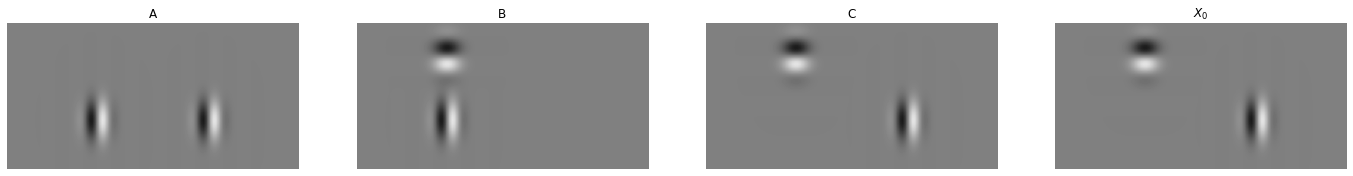

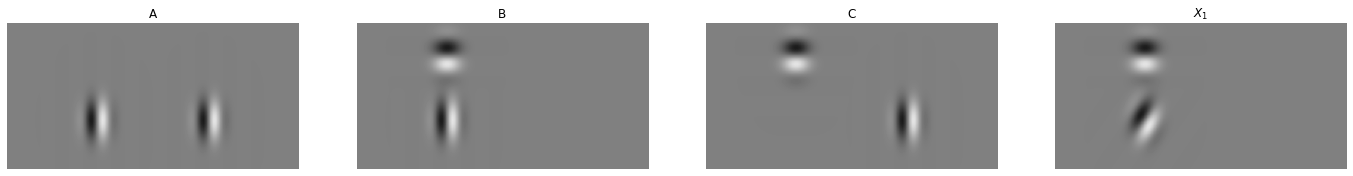

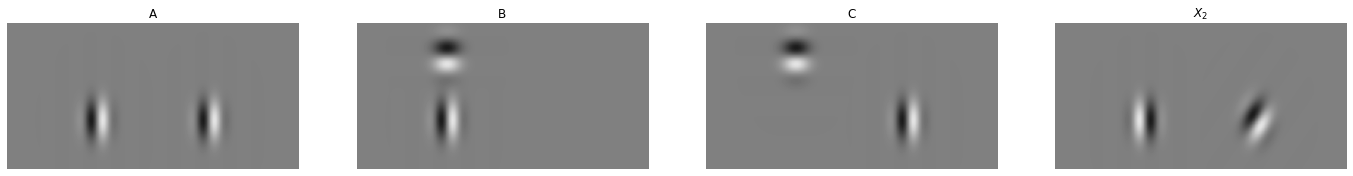

In [58]:
# Create + plot sequences
all_seq = []
all_input = []
num_rep = 15
for i in range(len(gi_nov)):
    stim_i = gi_fam + [gi_nov[i]]
    stim_unique = np.stack(stim_i)
    stim_idx    = list(range(len(gi_fam)))*num_rep + [len(gi_fam)]
    seq_vec     = (stim_unique,stim_idx)
    all_input.append(seq_vec)

    f,ax = plt.subplots(1,len(stim_i),figsize=(len(stim_i)*6,3))
    titles = ['A','B','C',f'$X_{i}$']
    for j in range(len(stim_i)):
        ax[j].imshow(stim_i[j],cmap='gray',vmin=-1,vmax=1)
        ax[j].axis('off')
        ax[j].set_title(titles[j])   

## Get maximally activating image for a given kernel

In [78]:
from scipy import ndimage as ndi

Maximum activation: 0.15819429304349167


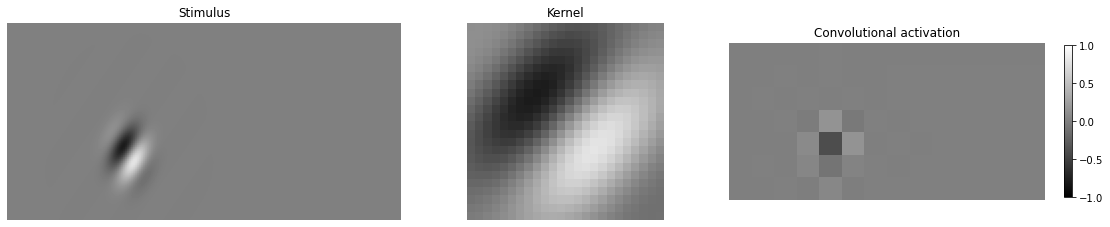

In [104]:
# Create Gabor images for toy experiment (3 familiar, 3 different novel)
orientations = np.array([0.25]) *np.pi
phases = np.array([-0.5])*np.pi
loc_idx = np.array([0])
widths = np.array([8.3])
frequencies = np.array([0.04])

# Convert loc_idx into x-y coordinates
loc_to_xy = {0: [-50,40], 1: [50,40], 2: [-50,0], 3: [50,0]}
loc_x = np.array([loc_to_xy[j][0] for j in loc_idx])
loc_y = np.array([loc_to_xy[j][1] for j in loc_idx])

# Create dataframe
kcl_df = pd.DataFrame(dict(zip(gs.dim_names,[orientations.flatten(),phases.flatten(),frequencies.flatten(),widths.flatten(),loc_x.flatten(),loc_y.flatten()])))
kcl = kcl_df.to_numpy().transpose()

# Set stimulus + kernels 
stim,_ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],kcl[:,0].reshape((-1,1)),resolution=100,magn=1)
k = k_params['ref_gabors_im'][0]
f,ax = plt.subplots(1,3,figsize=(20,4),gridspec_kw={'width_ratios': [2, 1, 2]})
ax[0].imshow(stim,cmap='gray',vmin=-1,vmax=1)
ax[0].axis('off')
ax[0].set_title('Stimulus')
ax[1].imshow(k,cmap='gray',vmin=-1,vmax=1)
ax[1].axis('off')
ax[1].set_title('Kernel')

# Compute activation of kernel by image
dens = 15
norm = (np.linalg.norm(stim.flatten()) * np.linalg.norm(k.flatten()))
if norm == 0:
    conv = np.nan*np.ones(stim[::dens,::dens].shape)
else:
    conv = ndi.convolve(stim, k, mode='constant')[::dens,::dens] / norm 

# Plot convolutional activation
im = ax[2].imshow(conv,cmap='gray',vmin=-1,vmax=1)
ax[2].axis('off')
ax[2].set_title('Convolutional activation')
f.colorbar(im, ax=ax[2],shrink=0.7)
print('Maximum activation:',np.max(conv))


## Run toy experiment

In [59]:
data = []
kl = []
kwl = []
for i in range(len(all_input)):
    stim = all_input[i]
    data_i, kl_gabor, kwl_gabor = gknov2.run_gabor_knov_withparams_flr(stim,k_params,plot_kernels=False,save_plot=False,save_plot_dir='',save_plot_name='',idx=True,parallel_k=False,flip=False,kmat_seq_flipped=None,stop_nokernels=True)
    data.append(data_i)
    kl.append(kl_gabor)
    kwl.append(kwl_gabor)

In [64]:
list(all_input[0][1])

[0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 3]

In [65]:
data[0]

nt        pt
0   4.931501  0.007216
1   4.275634  0.013903
2   3.980995  0.018667
3   3.341403  0.035387
4   3.146700  0.042994
5   2.977303  0.050930
6   2.800434  0.060784
7   2.642619  0.071175
8   2.477069  0.083989
9   2.519508  0.080499
10  2.344203  0.095924
11  2.167386  0.114476
12  2.350731  0.095299
13  2.145571  0.117001
14  1.954928  0.141575
15  2.241944  0.106252
16  2.004557  0.134720
17  1.800095  0.165283
18  2.168998  0.114292
19  1.900256  0.149530
20  1.682590  0.185892
21  2.118894  0.120165
22  1.820871  0.161885
23  1.590728  0.203777
24  2.083936  0.124439
25  1.759161  0.172189
26  1.517236  0.219317
27  2.059280  0.127546
28  1.710404  0.180793
29  1.457325  0.232858
30  2.041743  0.129802
31  1.671383  0.187987
32  1.407710  0.244703
33  2.029173  0.131444
34  1.639832  0.194013
35  1.366064  0.255109
36  2.020087  0.132644
37  1.614107  0.199068
38  1.330691  0.264294
39  2.013452  0.133527
40  1.592992  0.203316
41  1.300336  0.272440
42  2.008539  0.134185
43  1.575568  0.206890
44  1.274046  0.279698
45  1.243608  0.288342

(array([578.,  18.,  18.,  10.,   8.,   9.,   4.,   2.,   1.,   2.]),
 array([1.80197737e-17, 2.46096220e-05, 4.92192439e-05, 7.38288659e-05,
        9.84384879e-05, 1.23048110e-04, 1.47657732e-04, 1.72267354e-04,
        1.96876976e-04, 2.21486598e-04, 2.46096220e-04]),
 <BarContainer object of 10 artists>)

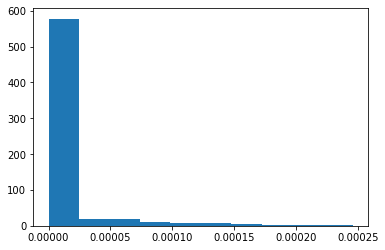

In [72]:
plt.hist(kl[0][0][np.where(kl[0][0] != 0)])


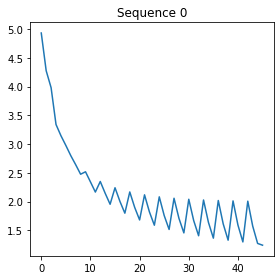

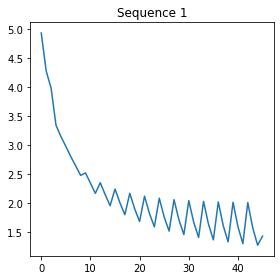

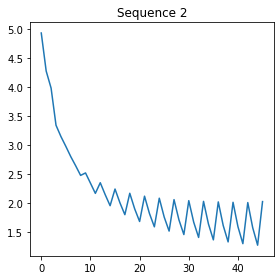

In [60]:
for i in range(len(data)):
    f,ax = plt.subplots(1,1,figsize=(4,4))
    ax.plot(np.arange(len(data[i])),data[i]['nt'])
    ax.set_title(f'Sequence {i}')
    f.tight_layout()

# Generate parent and child stimuli

In [2]:
def cosine_sim(a,b):
    return np.dot(a.flatten(),b.flatten()) / (np.linalg.norm(a.flatten()) * np.linalg.norm(b.flatten()))

def orientation_sim_pergabor(a,b):
    return np.cos(a.flatten()-b.flatten())

def orientation_sim(a,b):
    return np.mean(np.heaviside(0.25*np.pi-np.abs(a.flatten()-b.flatten())%(2*np.pi),0))

def orientation_phase_sim(a,b): # num_samples x 2 (orientation, phase)
    return np.mean([np.mean(np.cos(a[0,:].flatten()-b[0,:].flatten())),np.mean(np.abs(a[1,:].flatten()-b[1,:].flatten()))])

In [3]:
# Compute kernel activation matrix
def compute_kernel_matrix(stim,k_params,idx=True,conv=True,parallel_k=False):   
    ksig0 = k_params['ksig']   
    k = k_params['k']
    if idx:
        stim_unique = stim[0]
        stim_idx    = stim[1]
    else:
        stim_unique = stim
        stim_idx    = list(np.arange(stim.shape[0]))
    # Initialize novelty
    if conv:
        cdens = k_params['cdens']
        num_conv = stim_unique[0,::cdens,::cdens].size
        knum = len(k) * num_conv
        kwl, kmat, kmat_seq, _, _, _ = knov_vec.init_nov_conv(k,ksig0,num_conv,seq=stim_unique,parallel=parallel_k)
    else:
        knum = len(k)
        kwl, kmat, kmat_seq, _, _, _ = knov_vec.init_nov(k,ksig0,seq=stim_unique,parallel=parallel_k)
    return kmat_seq


In [4]:
# Compute parent-child similarity
def comp_parent_sim(parent,list_children,sim_meas='cosine_sim'):
    parent_sim = []
    for i in range(len(list_children)):
        parent_sim.append(eval(sim_meas)(parent.flatten(),list_children[i].flatten()))
    return parent_sim

# Compute pairwise similarity
def comp_pairwise_sim(list_children,sim_meas='cosine_sim'):
    pairwise_sim = np.ones((len(list_children),len(list_children)))
    for i in range(len(list_children)):
        for j in range(i+1,len(list_children)):
            sim_ij = eval(sim_meas)(list_children[i].flatten(),list_children[j].flatten())
            pairwise_sim[i][j] = sim_ij
            pairwise_sim[j][i] = sim_ij
    return pairwise_sim

def plot_parent_sim(parent_sim,f,ax):
    # Plot parent and pairwise similarity
    bars = ax.bar(np.arange(len(parent_sim)),parent_sim,color='grey')
    # a_mu = ax[0].axhline(np.mean(parent_sim),color='black',linestyle='--')
    ax.set_title('Parent-child similarity')
    ax.set_xlabel('Child stimulus')
    ax.set_ylabel('Similarity')
    ax.set_ylim([np.max([0,np.min(parent_sim)-0.1]),np.min([1,np.max(parent_sim)+0.1])])
    ax.bar_label(bars,fmt='%.2f')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([f'Mean={np.round(np.mean(parent_sim),2)}'],loc='upper right')

def plot_pairwise_sim_matrix(pairwise_sim,f,ax):
    asim = ax.imshow(pairwise_sim,cmap='bwr',norm=colors.CenteredNorm(vcenter=np.mean(pairwise_sim.flatten())))    
    for i in range(pairwise_sim.shape[0]):
        for j in range(pairwise_sim.shape[1]):
            ax.text(j, i, np.round(pairwise_sim[i, j],2), ha="center", va="center", color="k")
    ax.set_title('Pairwise similarity of children')
    ax.set_xticks(np.arange(pairwise_sim.shape[0]))
    ax.set_yticks(np.arange(pairwise_sim.shape[1]))
    f.colorbar(asim, ax=ax,shrink=0.7)

def plot_pairwise_sim_hist(all_sim,f,ax,title='Pairwise similarity distribution',xlabel='Similarity'):
    ax.hist(all_sim,bins=30,color='grey',alpha=1)
    ylim = ax.get_ylim()
    mu = np.mean(all_sim)
    sigma = np.std(all_sim)
    a_mu = ax.axvline(mu,color='black',linestyle='--')
    a_sigma = ax.fill_between([mu-sigma,mu+sigma],[0]*2,[ylim[1]+0.1]*2,color='black',alpha=0.2)
    ax.set_ylim(ylim)    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([a_mu,a_sigma],[f'Mean={np.round(mu,2)}',f'Std={np.round(sigma,2)}'],loc='upper right')

def plot_sim(parent_sim, pairwise_sim):

    f,ax = plt.subplots(1,3,figsize=(20,6))

    # Plot parent and pairwise similarity
    plot_parent_sim(parent_sim,f,ax[0])

    # Plot pairwise similarity
    plot_pairwise_sim_matrix(pairwise_sim,f,ax[1])

    # Plot pairwise similarity histogram
    all_sim = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
    plot_pairwise_sim_hist(all_sim,f,ax[2])

    f.tight_layout()


## Generate + plot parent stimulus

Text(0.5, 1.0, 'Parent stimulus')

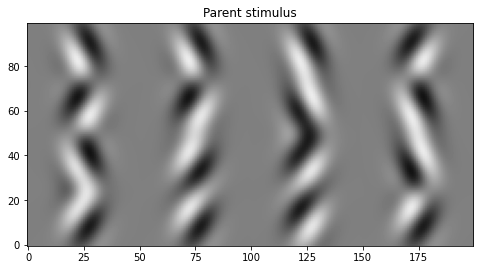

In [73]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0.714197,gabor_num=(4,4))
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
# ax.axis('off')
ax.set_title('Parent stimulus')

In [74]:
df_parent = pd.DataFrame(dict(zip(gs.dim_names,[parent[i,:] for i in range(parent.shape[0])])))
df_parent

orientation     phase  frequency     width  x-position  y-position
0      5.426586  1.570796       0.04  8.333333       -97.5       -8.75
1      5.426586  1.570796       0.04  8.333333       -32.5       -8.75
2      2.284993  1.570796       0.04  8.333333        32.5       -8.75
3      5.426586  1.570796       0.04  8.333333        97.5       -8.75
4      0.714197  1.570796       0.04  8.333333       -97.5       13.75
5      5.426586  1.570796       0.04  8.333333       -32.5       13.75
6      2.284993  1.570796       0.04  8.333333        32.5       13.75
7      3.855790  1.570796       0.04  8.333333        97.5       13.75
8      2.284993  1.570796       0.04  8.333333       -97.5       36.25
9      2.284993  1.570796       0.04  8.333333       -32.5       36.25
10     3.855790  1.570796       0.04  8.333333        32.5       36.25
11     0.714197  1.570796       0.04  8.333333        97.5       36.25
12     0.714197  1.570796       0.04  8.333333       -97.5       58.75
13     0.714197  1.570796       0.04  8.333333       -32.5       58.75
14     0.714197  1.570796       0.04  8.333333        32.5       58.75
15     2.284993  1.570796       0.04  8.333333        97.5       58.75

## Generate + plot child stimuli

In [117]:
# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=10,fun_transform=[gs.transform_identity,gs.transform_rotate],prob_transform=[0.44,0.56])

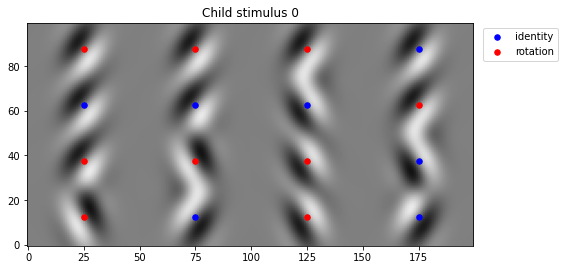

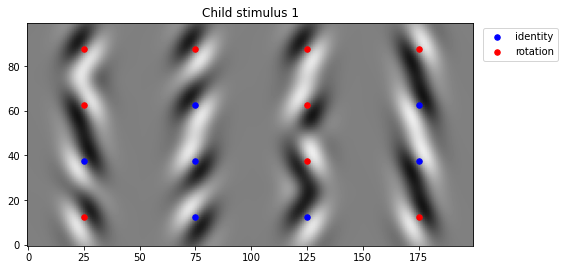

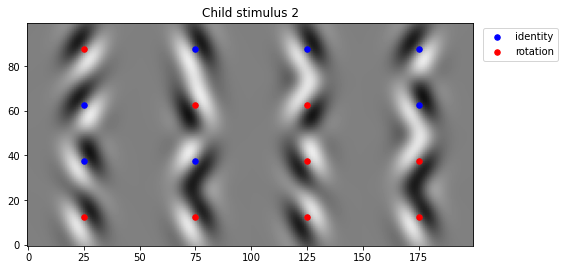

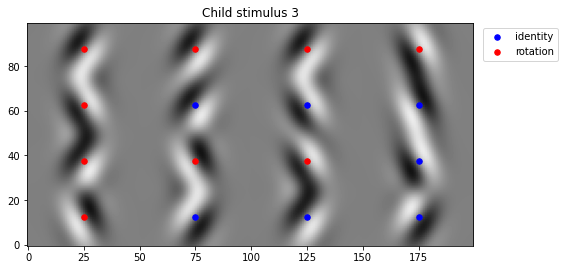

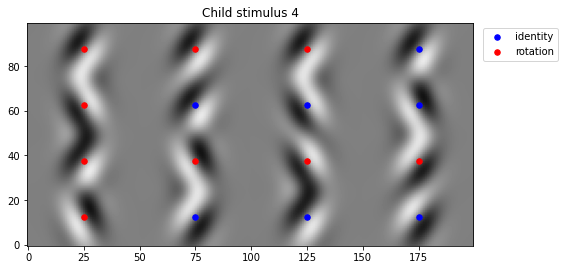

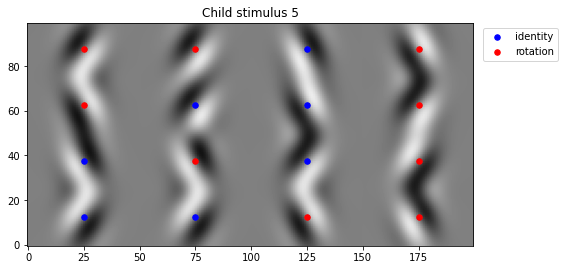

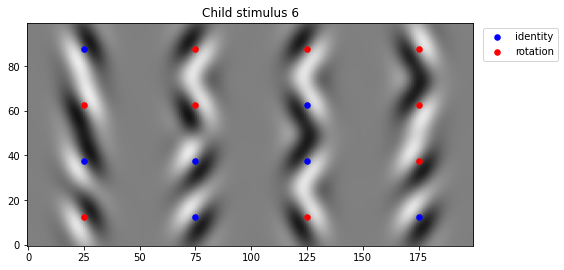

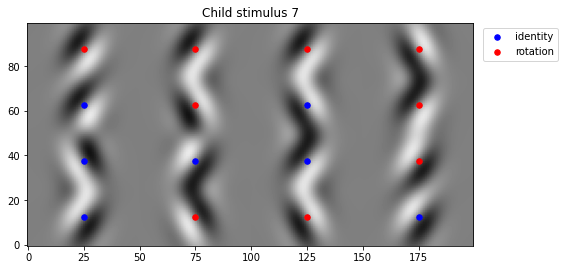

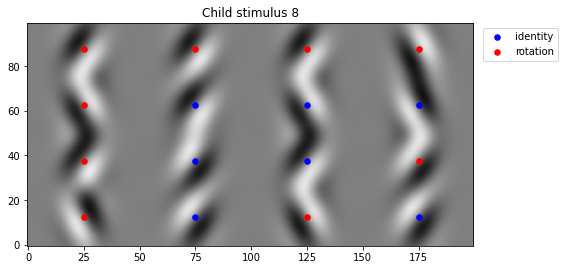

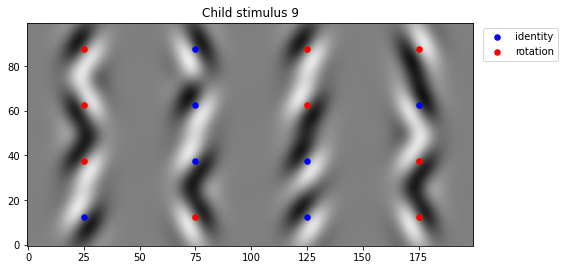

In [118]:
# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

## Compute pixel-based similarities

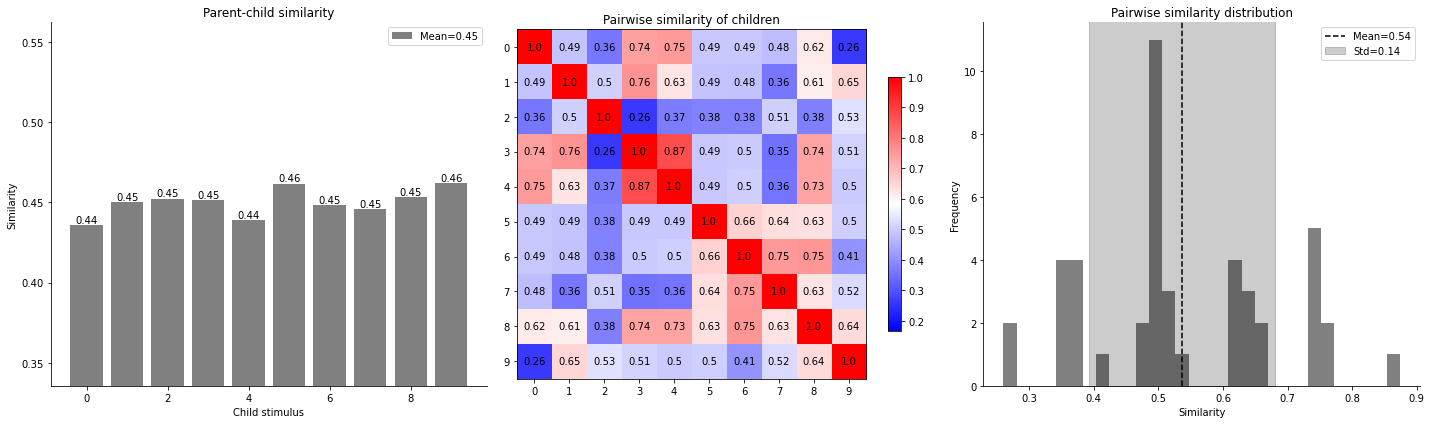

In [119]:
# Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)

## Compute feature-based similarities

In [120]:
df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
print(len(df_children[0]))
df_parent = pd.DataFrame(dict(zip(gs.dim_names,parent)))
print(len(df_parent))

sim_features = ['orientation']

16
16


In [121]:
feature_diff = df_parent[sim_features].rename({'orientation':'parent_orientation'},axis=1)
feature_diff = feature_diff.merge(df_children[0][sim_features],left_index=True,right_index=True).rename({'orientation':'child_orientation'},axis=1)
feature_diff[['parent_orientation','child_orientation']] = feature_diff[['parent_orientation','child_orientation']]/np.pi
feature_diff[f'orientation_diff'] = (df_parent[sim_features].values-df_children[0][sim_features].values)/np.pi
feature_sim = pd.DataFrame({'feature similarity':np.round(np.cos(df_parent[sim_features].to_numpy()-df_children[0][sim_features].to_numpy()),4).flatten()})
feature_diff = feature_diff.merge(feature_sim,left_index=True,right_index=True) 
print(feature_diff[['parent_orientation','child_orientation','orientation_diff']])
print(f'Total Gabors changed: {np.sum(((df_parent[sim_features]-df_children[1][sim_features])/np.pi).values!=0)}')

    parent_orientation  child_orientation  orientation_diff
0             1.727336           2.227336              -0.5
1             1.727336           1.727336               0.0
2             0.727336           1.227336              -0.5
3             1.727336           1.727336               0.0
4             0.227336           0.727336              -0.5
5             1.727336           2.227336              -0.5
6             0.727336           1.227336              -0.5
7             1.227336           1.227336               0.0
8             0.727336           0.727336               0.0
9             0.727336           0.727336               0.0
10            1.227336           1.227336               0.0
11            0.227336           0.727336              -0.5
12            0.227336           0.727336              -0.5
13            0.227336           0.727336              -0.5
14            0.227336           0.727336              -0.5
15            0.727336           0.72733

In [122]:
print(feature_diff[['orientation_diff','feature similarity']])


    orientation_diff  feature similarity
0               -0.5                 0.0
1                0.0                 1.0
2               -0.5                 0.0
3                0.0                 1.0
4               -0.5                 0.0
5               -0.5                 0.0
6               -0.5                 0.0
7                0.0                 1.0
8                0.0                 1.0
9                0.0                 1.0
10               0.0                 1.0
11              -0.5                 0.0
12              -0.5                 0.0
13              -0.5                 0.0
14              -0.5                 0.0
15               0.0                 1.0


(-0.05, 1.05)

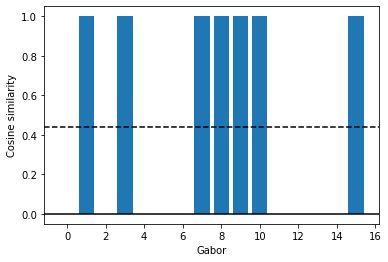

In [123]:
sim_i = orientation_sim_pergabor(df_parent[sim_features].to_numpy(),df_children[0][sim_features].to_numpy())
# print(sim_i)
plt.bar(np.arange(len(sim_i)),sim_i.flatten())
plt.axhline(0,color='black',linestyle='-')
plt.axhline(np.mean(sim_i),color='black',linestyle='--')
plt.xlabel('Gabor')
plt.ylabel('Cosine similarity')
plt.ylim([-0.05,1.05])

In [124]:
# Compute feature-based similarity to parent 
list_children_features = [df_children[i][sim_features].to_numpy() for i in range(len(df_children))]  
parent_features = df_parent[sim_features].to_numpy()  

parent_sim = comp_parent_sim(parent_features,list_children_features,sim_meas='orientation_sim')

# parent_sim = []  
# for i in range(len(df_children)):
#     sim_i = np.mean(np.cos(df_parent[sim_features].to_numpy()-df_children[i][sim_features].to_numpy()))
#     parent_sim.append(sim_i)

In [125]:
# Compute pairwise feature-based similarity
pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')
                                 
# pairwise_sim = np.ones((len(df_children),len(df_children)))
# for i in range(len(df_children)):
#     for j in range(i+1,len(df_children)):
#         sim_ij = np.mean(np.cos(df_children[i][sim_features].to_numpy()-df_children[j][sim_features].to_numpy()))
#         pairwise_sim[i][j] = sim_ij
#         pairwise_sim[j][i] = sim_ij

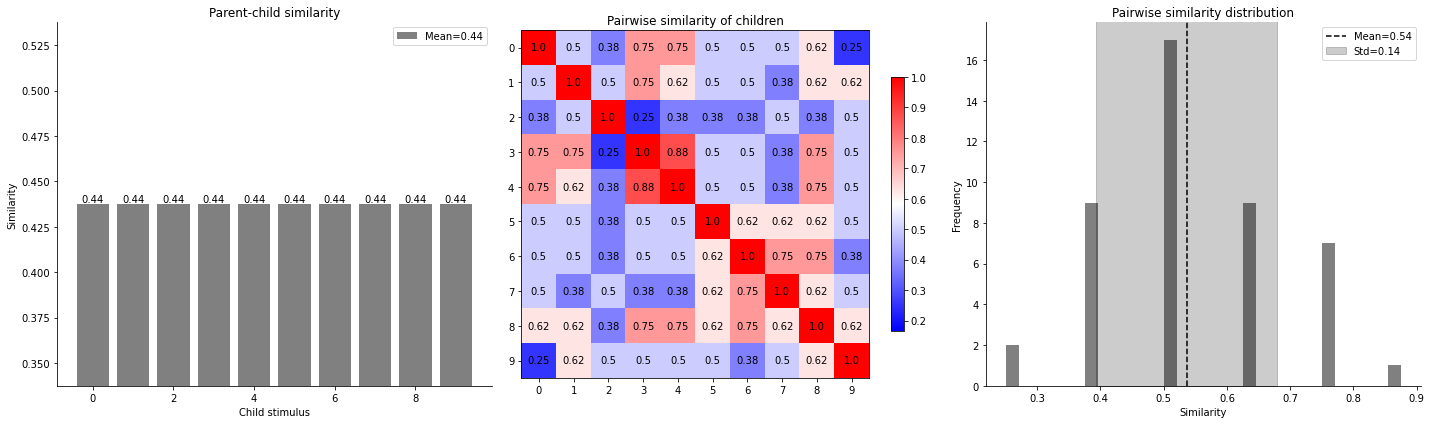

In [126]:
# Plot parent and pairwise similarity   
plot_sim(parent_sim, pairwise_sim)

## Compute kernel-based similarities

orientation     phase  frequency     width  x-position  y-position
0     0.714197 -1.570796       0.04  8.333333         0.0         0.0
1     2.284994 -1.570796       0.04  8.333333         0.0         0.0
2     0.714197  1.570796       0.04  8.333333         0.0         0.0
3     2.284994  1.570796       0.04  8.333333         0.0         0.0

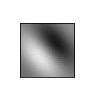

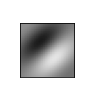

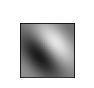

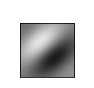

In [127]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
k_params['ref_gabors']

In [128]:
vec_children = np.stack(im_children)
print(vec_children.shape)

vec_parent = im_parent[None,:,:]
print(vec_parent.shape)

(10, 100, 200)
(1, 100, 200)


In [129]:
kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
print(kmat_parent.shape)

kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
print(len(kernels_children))
print(kernels_children[0].shape)

(1300,)
10
(1300,)


In [130]:
cosine_sim(kmat_parent,kernels_children[0])

0.5466504846206772

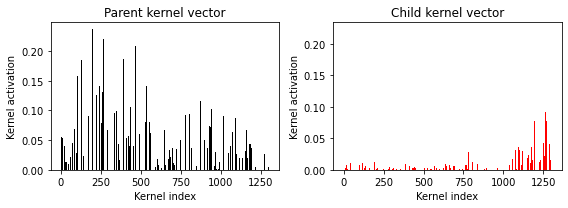

In [131]:
f,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].bar(np.arange(kmat_parent.shape[0]),kmat_parent,color='k')
ax[1].bar(np.arange(kmat_children.shape[0]),kmat_children[:,0],color='r')
ax[0].set_title('Parent kernel vector')
ax[1].set_title('Child kernel vector')
ax[0].set_xlabel('Kernel index')
ax[1].set_xlabel('Kernel index')
ax[0].set_ylabel('Kernel activation')
ax[1].set_ylabel('Kernel activation')
f.tight_layout()

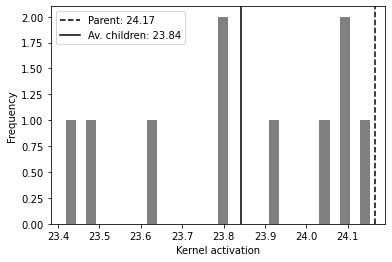

In [137]:
kact_parent = np.sum(kmat_parent)
kact_children = [np.sum(kmat_children[:,i]) for i in range(kmat_children.shape[1])]
mu_kact_children = np.mean(kact_children)

plt.hist(kact_children,bins=30,color='grey',alpha=1)
a1 = plt.axvline(kact_parent,color='black',linestyle='--')
a2 = plt.axvline(mu_kact_children,color='black',linestyle='-')
plt.xlabel('Kernel activation')
plt.ylabel('Frequency')
plt.legend([a1,a2],[f'Parent: {np.round(kact_parent,2)}',f'Av. children: {np.round(mu_kact_children,2)}'])

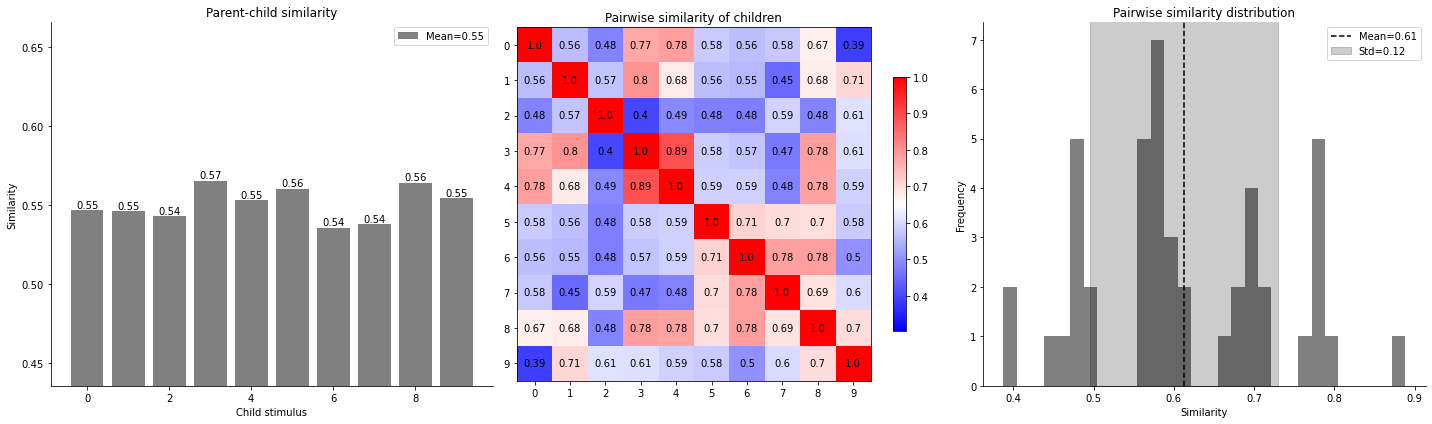

In [132]:
# Compute parent-children similarity
parent_sim = comp_parent_sim(kmat_parent,kernels_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(kernels_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)

# Generate iterative sequence of images with same feature overlap

In [37]:
num_child = 10

# Generate children
init_child_full, vals_gabor = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0.714197,gabor_num=(4,4))
print(vals_gabor)
print(vals_gabor[0].shape)
children, overlap = gs.generate_teststim_iterative_1d(init_child_full,vals_gabor[0],num_child,field_transform=[0],prob_overlap=[0.2],rng=None)

[array([[0.714197  ],
       [2.28499333],
       [3.85578965],
       [5.42658598]])]
(4, 1)
Required overlap between children is too large to sample additional children. Number of children returned: 5.


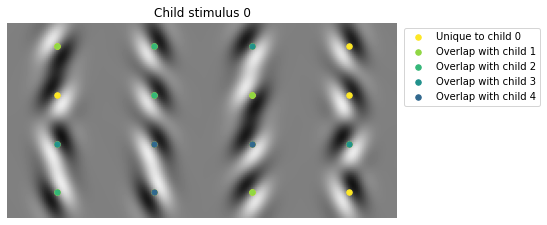

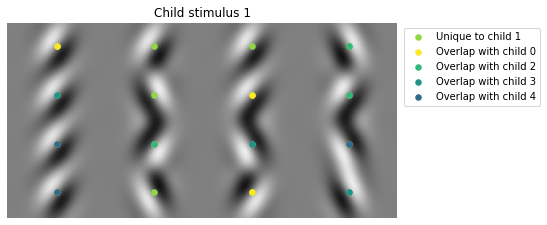

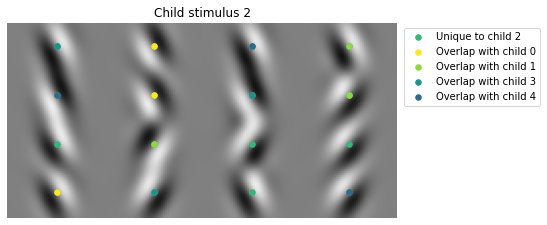

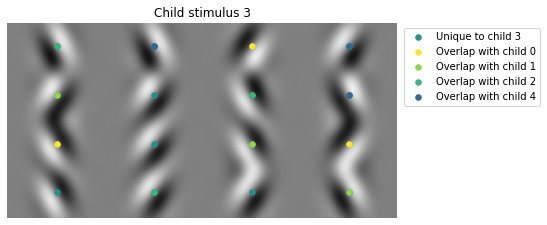

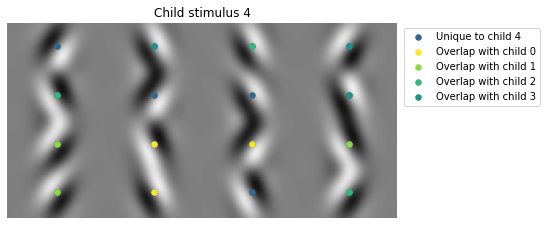

In [27]:
# Plot children
child_colors = vis.prep_cmap('viridis',len(children))

im_children = []
f_children = []
ax_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)

    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    ax.set_title(f'Child stimulus {i}')
    f_children.append(f)
    ax_children.append(ax)

    # Plot all Gabors of current child i into plot of child i
    xloc_i = (children[i][4,:] + 130)*200/260 
    yloc_i = (children[i][5,:] + 20)*100/90
    ax.scatter(xloc_i,yloc_i,s=30,color=child_colors[i],label=f'Unique to child {i}') 

    # Plot overlap between currently plotted image i and previous images j 
    for j in range(len(overlap[i])):
        xloc_same = (children[j][4,overlap[i][j]] + 130)*200/260 
        yloc_same = (children[j][5,overlap[i][j]] + 20)*100/90
        ax.scatter(xloc_same,yloc_same,s=30,color=child_colors[j],label=f'Overlap with child {j}') # Plot overlap with child j into plot of current child i
        ax_children[j].scatter(xloc_same,yloc_same,s=30,color=child_colors[i],label=f'Overlap with child {i}') # Plot overlap with current child i into plot of child j
    
for i in range(len(f_children)):
    ax_children[i].legend(bbox_to_anchor=(1.38,1),loc='upper right')
    f_children[i].tight_layout()

16
[[1.     0.1875 0.1875 0.1875 0.1875]
 [0.1875 1.     0.1875 0.1875 0.1875]
 [0.1875 0.1875 1.     0.1875 0.1875]
 [0.1875 0.1875 0.1875 1.     0.1875]
 [0.1875 0.1875 0.1875 0.1875 1.    ]]
[0.1875 0.1875 0.1875 0.1875 0.1875 0.1875 0.1875 0.1875 0.1875 0.1875]


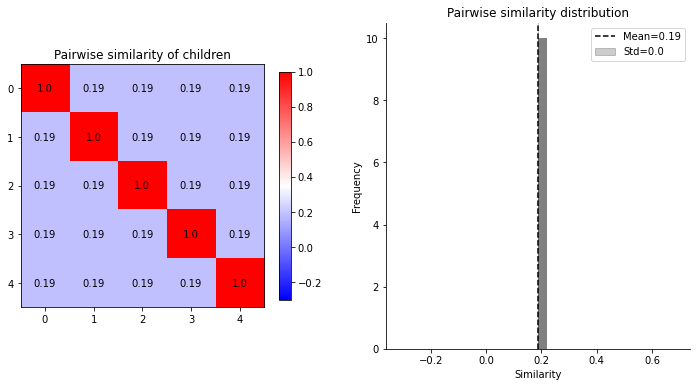

In [28]:
# Compute feature-based pairwise similarity
df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
print(len(df_children[0]))

sim_features = ['orientation']
list_children_features = [df_children[i][sim_features].to_numpy() for i in range(len(df_children))]  

pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])

[[ 1.         -0.17274708 -0.07335115 -0.16262298  0.00779227]
 [-0.17274708  1.          0.12953172  0.00182239  0.05724283]
 [-0.07335115  0.12953172  1.         -0.10165585 -0.06750988]
 [-0.16262298  0.00182239 -0.10165585  1.          0.10670416]
 [ 0.00779227  0.05724283 -0.06750988  0.10670416  1.        ]]
[-0.17274708 -0.07335115 -0.16262298  0.00779227  0.12953172  0.00182239
  0.05724283 -0.10165585 -0.06750988  0.10670416]


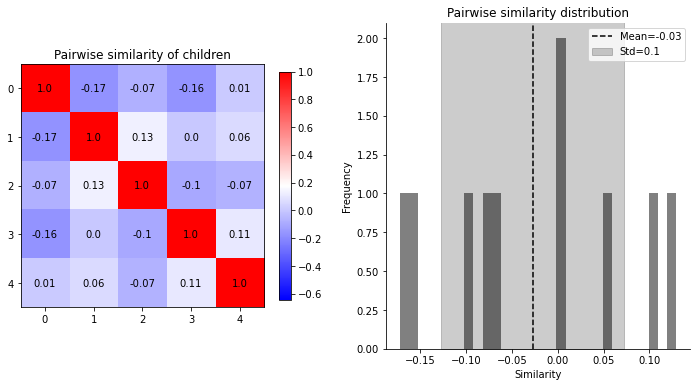

In [29]:
# Compute pixel-based pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot pixel-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])

   orientation     phase  frequency     width  x-position  y-position
0     0.714197 -1.570796       0.04  8.333333         0.0         0.0
1     2.284994 -1.570796       0.04  8.333333         0.0         0.0
2     0.714197  1.570796       0.04  8.333333         0.0         0.0
3     2.284994  1.570796       0.04  8.333333         0.0         0.0
(5, 100, 200)
5
(1300,)
[[1.         0.25589856 0.23140747 0.26458257 0.30340904]
 [0.25589856 1.         0.30463125 0.29621543 0.31770803]
 [0.23140747 0.30463125 1.         0.27630097 0.27650032]
 [0.26458257 0.29621543 0.27630097 1.         0.33456353]
 [0.30340904 0.31770803 0.27650032 0.33456353 1.        ]]
[0.25589856 0.23140747 0.26458257 0.30340904 0.30463125 0.29621543
 0.31770803 0.27630097 0.27650032 0.33456353]


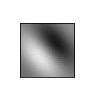

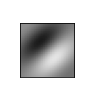

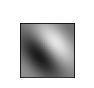

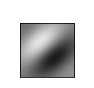

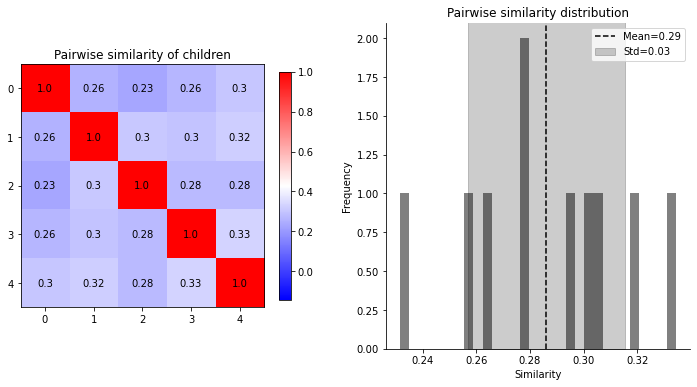

In [30]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
print(k_params['ref_gabors'])

vec_children = np.stack(im_children)
print(vec_children.shape)

kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
print(len(kernels_children))
print(kernels_children[0].shape)

pairwise_sim = comp_pairwise_sim(kernels_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])

# Generate iterative sequences (multiple features)

In [48]:
num_child = 4
p_sim = 0.1

# Generate children (1D)
init_child_full1, features1 = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0.714197,gabor_num=(4,4),return_features=[0])
print(features1)
children1, overlap1 = gs.generate_teststim_iterative_1d(init_child_full1,features1[0],num_child,field_transform=[0],prob_overlap=[p_sim],rng=None)

# Generate children (2D)
init_child_full2, features2 = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0.714197,gabor_num=(4,4),return_features=[0,4])
print(features2)
children2, overlap2 = gs.generate_teststim_iterative(init_child_full2,features2,num_child,field_transform=[0,4],prob_overlap=[p_sim],rng=None)

[array([[0.714197  ],
       [2.28499333],
       [3.85578965],
       [5.42658598]])]
[array([[0.714197  ],
       [2.28499333],
       [3.85578965],
       [5.42658598]]), array([[-16.25],
       [  0.  ],
       [ 16.25]])]


Adding another dimension (i.e. more available features per gabor) does not increase the number of images we can generate - the limiting factor is the number of gabors that are allowed to overlap. We are still restricted to p_overlap = [0, 0.3] to produce 4 children.

However, with an additional dimension, the same p_overlap produces lower similarities 

# Generate random images (Homann-style)

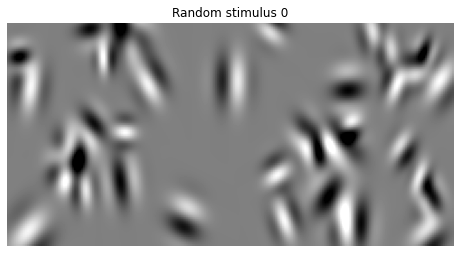

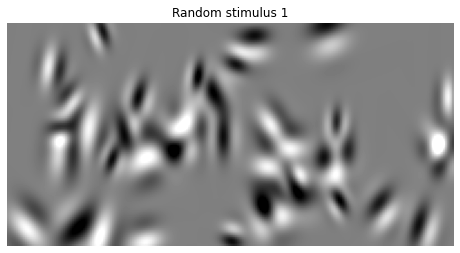

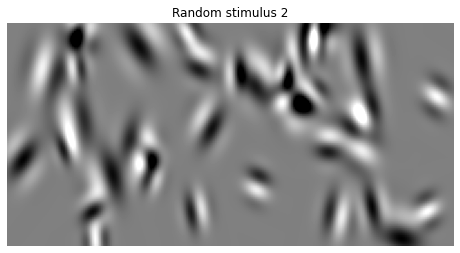

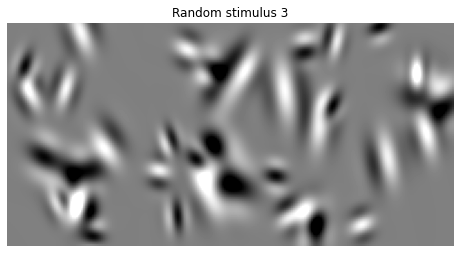

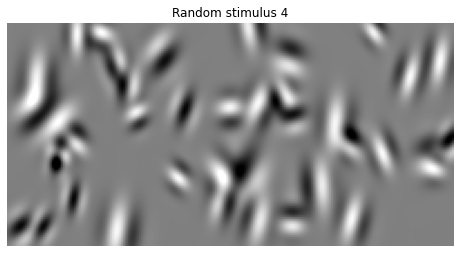

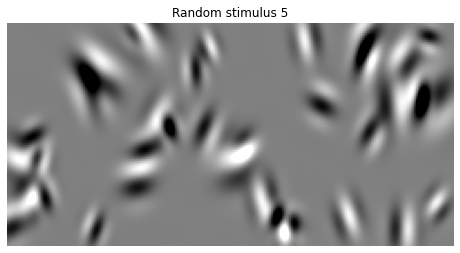

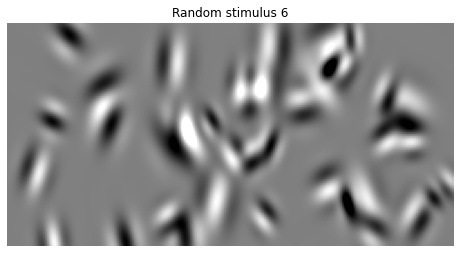

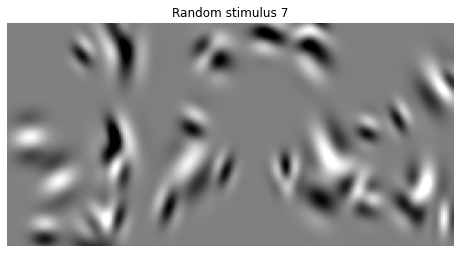

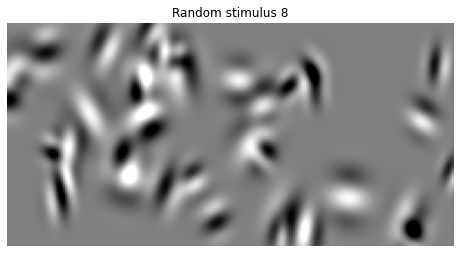

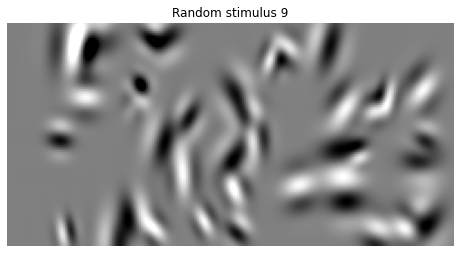

In [19]:
num_gabor = 40
num_im = 10
im_seed = 98765

random = gs.generate_stim(gs.dim_ranges_rad,num_gabor*num_im,np.random.default_rng(im_seed))
df_random = pd.DataFrame(random.transpose(),columns=gs.dim_names.copy())

im_random = []
for i in range(num_im):
    im_i,_ = gs.comp_gabor(gs.dim_ranges_rad[4],gs.dim_ranges_rad[5],random[:,i*num_gabor:(i+1)*num_gabor],resolution=100,magn=1)
    im_random.append(im_i)

    # Plot 
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_i,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    ax.set_title(f'Random stimulus {i}')

[[ 1.          0.03258322  0.05288235  0.03443708  0.05295622 -0.0146456
  -0.01474455  0.04080053 -0.00149064 -0.00906991]
 [ 0.03258322  1.          0.03453009  0.03177386 -0.10504048 -0.06705001
   0.12373694  0.02534795  0.06110499 -0.01728625]
 [ 0.05288235  0.03453009  1.         -0.00730748  0.04170515 -0.02169779
  -0.02919721 -0.06337752  0.01527761 -0.03752119]
 [ 0.03443708  0.03177386 -0.00730748  1.          0.011371    0.018035
  -0.02297577  0.0271516   0.03885466 -0.06334288]
 [ 0.05295622 -0.10504048  0.04170515  0.011371    1.          0.02087035
   0.02264333 -0.00855641 -0.0193754  -0.00539128]
 [-0.0146456  -0.06705001 -0.02169779  0.018035    0.02087035  1.
   0.03656296 -0.0099306   0.02878258 -0.06433768]
 [-0.01474455  0.12373694 -0.02919721 -0.02297577  0.02264333  0.03656296
   1.         -0.00917313 -0.00677382 -0.04421113]
 [ 0.04080053  0.02534795 -0.06337752  0.0271516  -0.00855641 -0.0099306
  -0.00917313  1.         -0.06141736  0.04923639]
 [-0.0014906

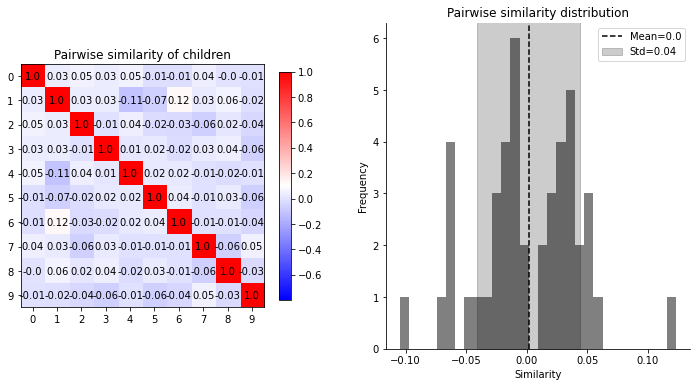

In [10]:
# Compute pixel-based pairwise similarity
pairwise_sim = comp_pairwise_sim(im_random)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot pixel-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])

   orientation     phase  frequency     width  x-position  y-position
0     0.714197 -1.570796       0.04  8.333333         0.0         0.0
1     2.284994 -1.570796       0.04  8.333333         0.0         0.0
2     0.714197  1.570796       0.04  8.333333         0.0         0.0
3     2.284994  1.570796       0.04  8.333333         0.0         0.0
(10, 100, 200)
10
(1300,)
[[1.         0.25300727 0.3018655  0.24796088 0.27542339 0.17538066
  0.21720761 0.2875007  0.21439958 0.22606763]
 [0.25300727 1.         0.24544381 0.24691125 0.21365543 0.15032968
  0.33328814 0.2369392  0.2969448  0.24686606]
 [0.3018655  0.24544381 1.         0.19110102 0.26126132 0.21549598
  0.22178791 0.18633627 0.23619016 0.18523178]
 [0.24796088 0.24691125 0.19110102 1.         0.23511336 0.24928599
  0.17969177 0.21663059 0.22698648 0.14317783]
 [0.27542339 0.21365543 0.26126132 0.23511336 1.         0.18312765
  0.22314955 0.20812653 0.2115319  0.25514148]
 [0.17538066 0.15032968 0.21549598 0.24928599 0.1

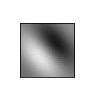

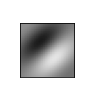

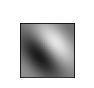

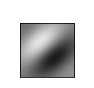

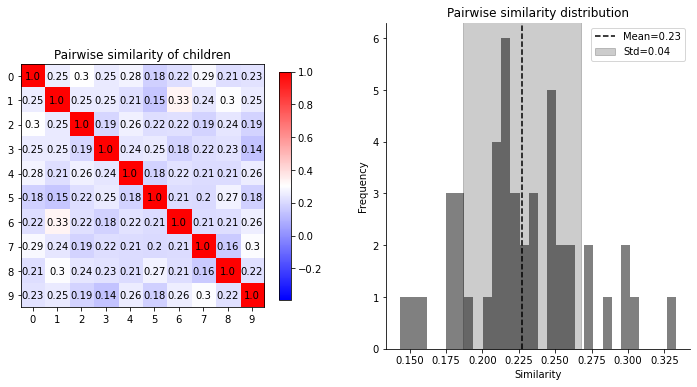

In [17]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
print(k_params['ref_gabors'])

vec_random = np.stack(im_random)
print(vec_random.shape)

kmat_random = compute_kernel_matrix((vec_random,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_random = [kmat_random[:,i] for i in range(kmat_random.shape[1])]
print(len(kernels_random))
print(kernels_random[0].shape)

pairwise_sim = comp_pairwise_sim(kernels_random)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])

# Simulate Homann (L-experiment) for given similarity level

## Functions

In [5]:
def generate_similar_input(sim_value,seed_parent,seed_child,num_parent,num_child_per_parent):
    # Children parameters
    transform_funs  = [gs.transform_identity,gs.transform_rotate]
    transform_probs = [sim_value,1-sim_value]
    transform_names = ['identity','rotation']
    transform_cols  = ['blue','red']

    # Experiment parameters
    sequence_mode = 'seq'
    n_fam = [1,3,8,18,38]
    len_fam = 3

    # Plot stimuli
    plot_stim = False

    # Generate input sequences
    all_parents = []
    all_children = []
    all_inputs = []

    for i in range(num_parent):
        # Generate parent stimulus
        parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,gabor_num=(4,4),rng=np.random.default_rng(seed_parent[i]))
        df_parent = pd.DataFrame(dict(zip(gs.dim_names,parent)))
        im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)
        all_parents.append((df_parent,im_parent))

        # Plot parent stimulus
        if plot_stim:
            f,ax = plt.subplots(1,1,figsize=(8,16))
            ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
            ax.axis('off')
            ax.set_title(f'Parent stimulus {i}')
        
        # Generate child stimuli (four for L-experiment)
        children, set_transform = gs.generate_teststim_children(parent,num_child=num_child_per_parent,fun_transform=transform_funs,prob_transform=transform_probs,rng=np.random.default_rng(seed_child[i]))
        df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
        im_children = []
        for j in range(len(children)):
            im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j],resolution=100,magn=1)
            im_children.append(im_child)

            # Plot children
            if plot_stim:
                f,ax = plt.subplots(1,1,figsize=(8,16))
                ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
                ax.axis('off')
                # Plot type of transform for each Gabor
                for k in range(len(set_transform[j])):
                    xloc = (children[j][4,set_transform[j][k]] + 130)*200/260
                    yloc = (children[j][5,set_transform[j][k]] + 20)*100/90
                    ax.scatter(xloc,yloc,s=30,color=transform_cols[k],label=transform_names[k])
                ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
                ax.set_title(f'Child stimulus {j} for parent {i}')  
        
        all_children.append((df_children,im_children))
        gfam = [im_children[j] for j in range(len_fam)]
        gnov = [im_children[len_fam]]
        
        # Generate input sequence
        if sequence_mode=='app':
            mode_factor = len(n_fam)
            modes = np.arange(mode_factor,dtype=int)
        else:
            mode_factor = 1
            modes = np.zeros(len(n_fam),dtype=int)

        vec_list  = []
        type_list = []
        for i, m in zip(range(len(n_fam)), modes):

            # Pick new set of familiar and novel images
            if len_fam==1: gfam_m = [gfam[m]]
            else:          gfam_m = gfam[m*len_fam:(m+1)*len_fam]
            gnov_m = gnov[m]

            # Create sequence
            stim_unique = np.stack(gfam_m + [gnov_m])
            stim_idx    = (list(np.arange(len(gfam_m)))*(n_fam[i]+2))[:-1] + [len(gfam_m)] + list(np.arange(len(gfam_m)))*2 # n_fam+1 repetitions of fam. sequ.; fam. sequ. with novel image substituted; 1 repetition of fam. sequ.
            seq_vec     = (stim_unique,stim_idx)
            stim_type   = (['fam']*len_fam*(n_fam[i]+2))[:-1] + ['nov'] + ['fam']*len_fam*2
            vec_list.append(seq_vec)
            type_list.append(stim_type)
        
        all_inputs.append((vec_list,type_list))
    return all_parents, all_children, all_inputs

In [6]:
def plot_similar_inputs(all_parents,all_children):
    # Plot parent-child and pairwise similarity distribution (feature-similarity)
    sim_features = ['orientation']

    all_parent_sim = []
    all_pairwise_sim = []
    all_hist_pairwise_sim = []
    for i in range(len(all_parents)):
        # Get parent features
        df_parent = all_parents[i][0]
        parent_features = df_parent[sim_features].to_numpy()  

        # Get children features 
        df_children = all_children[i][0]
        list_children_features = [df_children[j][sim_features].to_numpy() for j in range(len(df_children))]  

        # Compute similarities
        parent_sim = comp_parent_sim(parent_features,list_children_features,sim_meas='orientation_sim')
        pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')

        hist_pairwise_sim = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()

        all_parent_sim.append(parent_sim)
        all_pairwise_sim.append(pairwise_sim)
        all_hist_pairwise_sim.append(hist_pairwise_sim)

    print(np.concatenate(all_parent_sim))
    print(np.concatenate(all_hist_pairwise_sim))

    # Plot histogram of similarities
    f,ax = plt.subplots(1,2,figsize=(12,4))
    plot_pairwise_sim_hist(np.concatenate(all_parent_sim),f,ax[0],title='Parent-child similarity distribution',xlabel='Orientation similarity (cosine)')
    plot_pairwise_sim_hist(np.concatenate(all_hist_pairwise_sim),f,ax[1],title='Pairwise similarity distribution',xlabel='Orientation similarity (cosine)')

    return all_parent_sim, all_pairwise_sim, all_hist_pairwise_sim

In [7]:
# all_inputs: List of all inputs
# level 0: number of experiments (with different random seed)
# level 1: inputs and input types
# level 2: number of sub-experiments (one for each value of L)
# level 3: stimulus unique and stimulus index for each sub-experiment

def run_homann_l(n_fam,all_inputs,k_params,seed_parent):
    data = []; kl = []; kwl = []
    for i in range(len(all_inputs)):
        print(f'Running realization {i} of L-experiment.\n')
        stim = all_inputs[i][0]
        itype = all_inputs[i][1]

        data_i = []; kl_i = []; kwl_i = []
        for j in range(len(stim)):
            print(f'Running experiment condition {j} of experiment realization {i}.\n')
            stim_j = stim[j]
            data_ij, kl_gabor_ij, kwl_gabor_ij = gknov2.run_gabor_knov_withparams_flr(stim_j,k_params,plot_kernels=False,save_plot=False,save_plot_dir='',save_plot_name='',idx=True,parallel_k=False,flip=False,kmat_seq_flipped=None,stop_nokernels=True)
            data_ij['n_fam'] = [n_fam[j]]*len(data_ij) 
            data_ij['seed']  = [seed_parent[i]]*len(data_ij)  
            data_ij['stim_type'] = itype[j] 
            data_ij['sample_id'] = [i]*len(data_ij)    
            data_i.append(data_ij)
            kl_i.append(kl_gabor_ij)
            kwl_i.append(kwl_gabor_ij)
        data.append(data_i)
        kl.append(kl_i)
        kwl.append(kwl_i)
    return data, kl, kwl

In [8]:
def plot_homann_l(n_fam,data,all_parent_sim,all_pairwise_sim,all_hist_pairwise_sim,sim_level):
    alpha_list = np.linspace(1,0.2,len(n_fam))
    nov_resp_all = []
    for i in range(len(data)):
        f,ax = plt.subplots(1,5,figsize=(5*4,4))
        # Plot individual simulations
        for j in range(len(data[i])):
            ax[0].plot(np.arange(len(data[i][j])),data[i][j]['nt'],color='k',alpha=alpha_list[j])
            ax[0].set_title(f'L={n_fam[j]}')
        ax[0].set_xlabel('Time steps')
        ax[0].set_ylabel('Response traces')
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        # Plot novelty responses
        data_i = pd.concat(data[i])
        _,nov_resp_i = sd.get_nov_response(data_i,'n_fam')
        nov_resp_i = nov_resp_i.reset_index()
        nov_resp_all.append(nov_resp_i)
        ax[1].plot(nov_resp_i['n_fam'],nov_resp_i[('nt_norm','mean')],'o',color='k')
        ax[1].plot(nov_resp_i['n_fam'],nov_resp_i[('nt_norm','mean')],'--',color='k')

        # Plot similarities
        plot_parent_sim(all_parent_sim[i],f,ax[-3])
        plot_pairwise_sim_matrix(all_pairwise_sim[i],f,ax[-2])
        plot_pairwise_sim_hist(all_hist_pairwise_sim[i],f,ax[-1])

        f.suptitle(f'Experiment run {i}')
        f.tight_layout()
        path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/2024-10_single-trace-sim/sim-{sim_level}'
        sl.make_long_dirs(path_fig) 
        f.savefig(os.path.join(path_fig,f'homann_l-{i}.png'))

## Simulate experiment

In [9]:
num_parent = 10
num_child_per_parent = 4
init_seed = 12345

seed_parent = h_in.get_random_seed(length=5,n=num_parent,init_seed=init_seed)
seed_child = h_in.get_random_seed(length=5,n=num_parent*num_child_per_parent,init_seed=init_seed+1)

In [10]:
sim_values = np.array([0.25,0.5,0.75])

[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
[0.875 0.5   0.625 0.5   0.625 0.75  0.625 0.625 0.625 0.75  0.625 0.75
 0.5   0.5   0.625 0.625 0.625 0.5   0.625 0.5   0.625 0.625 0.75  0.625
 0.5   0.75  0.625 0.5   0.625 0.5   0.5   0.5   0.625 0.75  0.625 0.75
 0.625 0.5   0.625 0.5   0.75  0.625 0.5   0.75  0.5   0.625 0.625 0.625
 0.625 0.625 0.5   0.625 0.5   0.625 0.75  0.625 0.625 0.625 0.5   0.75 ]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5]
[0.75  0.5   0.5   0.5   0.25  0.375 0.5   0.375 0.625 0.75  0.5   0.375
 0.375 0.5   0.625 0.5   0.375 0.375 0.375 0.375 0.5   0.5   0.5   0.625
 0.5   0.625 0.375 0.625 0.5   0.375 0.625 0.625 0.5   0.25  0.375 0.625
 0.75  0.25  0.5   0.375 0.375 0.625 0.5   0.625 

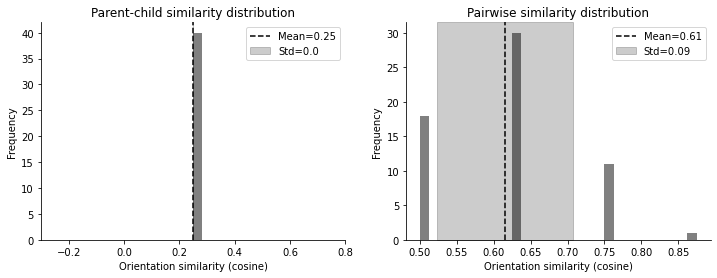

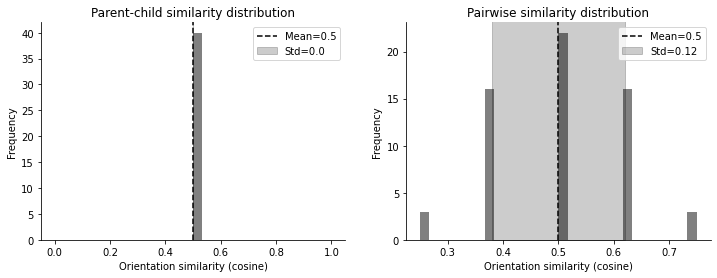

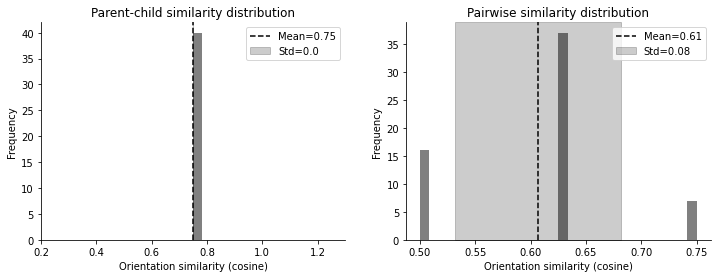

In [11]:
sv_inputs = []
sv_parents = []
sv_children = []
sv_sim = []
for sv in sim_values:
    all_parents, all_children, all_inputs = generate_similar_input(sv,seed_parent,seed_child,num_parent,num_child_per_parent)
    all_parent_sim, all_pairwise_sim, all_hist_pairwise_sim = plot_similar_inputs(all_parents,all_children)
    sv_inputs.append(all_inputs)
    sv_parents.append(all_parents)
    sv_children.append(all_children)
    sv_sim.append((all_parent_sim, all_pairwise_sim, all_hist_pairwise_sim))

dict_sv_inputs = dict(zip(sim_values,sv_inputs))

Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Running realization 1 of L-experiment.

Running experiment condition 0 of experiment realization 1.

Running experiment condition 1 of experiment realization 1.

Running experiment condition 2 of experiment realization 1.

Running experiment condition 3 of experiment realization 1.

Running experiment condition 4 of experiment realization 1.

Running realization 2 of L-experiment.

Running experiment condition 0 of experiment realization 2.

Running experiment condition 1 of experiment realization 2.

Running experiment condition 2 of experiment realization 2.

Running experiment condition 3 of experiment realization 2.

Running experiment conditi

/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple 

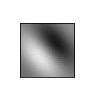

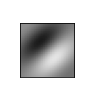

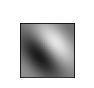

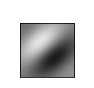

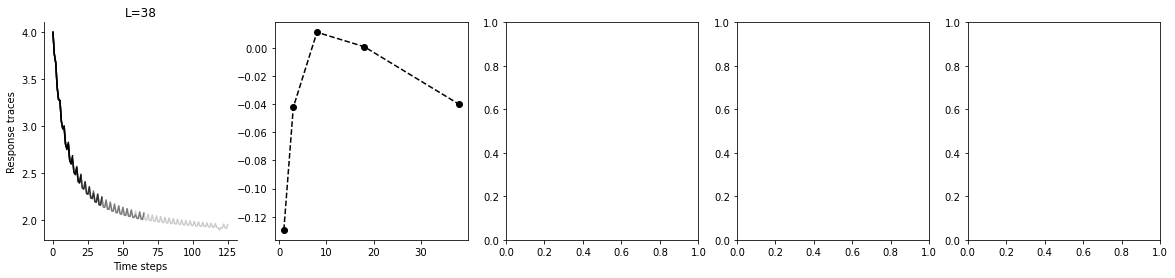

In [12]:
n_fam = [1,3,8,18,38]
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)

sv_data = []; sv_kl = []; sv_kwl = []
for i in range(len(sim_values)):
    data, kl, kwl = run_homann_l(n_fam,sv_inputs[i],k_params,seed_parent)
    sv_data.append(data)
    sv_kl.append(kl)
    sv_kwl.append(kwl)
    plot_homann_l(n_fam,data,sv_parents[i],sv_sim[i][1],sv_sim[i][2],sim_level=sim_values[i])

# Generate parent-child images with multiple transformations

In [5]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0.714197,gabor_num=(3,3),loc_sigma=(10,5))

df_parent = pd.DataFrame(dict(zip(gs.dim_names,[parent[i,:] for i in range(parent.shape[0])])))
df_parent

orientation     phase  frequency     width  x-position  y-position
0     0.714197  1.570796       0.04  8.333333  -91.300677  -14.187804
1     3.855790  1.570796       0.04  8.333333  -18.888441   -2.184779
2     2.284993  1.570796       0.04  8.333333   74.791727    4.787682
3     5.426586  1.570796       0.04  8.333333  -79.085222   30.369828
4     5.426586  1.570796       0.04  8.333333   14.136300   31.796397
5     3.855790  1.570796       0.04  8.333333   90.016488   22.311468
6     0.714197  1.570796       0.04  8.333333  -87.451687   57.206347
7     3.855790  1.570796       0.04  8.333333  -11.475877   53.974944
8     3.855790  1.570796       0.04  8.333333   80.916222   53.279433

In [6]:
fun_transform=[gs.transform_identity,
               gs.transform_rotate_left,
               gs.transform_rotate_right,
            #    gs.transform_shift_left,
               gs.transform_shift_right]
p_rotate = 0.2
prob_transform = [1-p_rotate] + [p_rotate/(len(fun_transform)-1)]*(len(fun_transform)-1)

# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=10,fun_transform=fun_transform,prob_transform=prob_transform,mode='fixed')

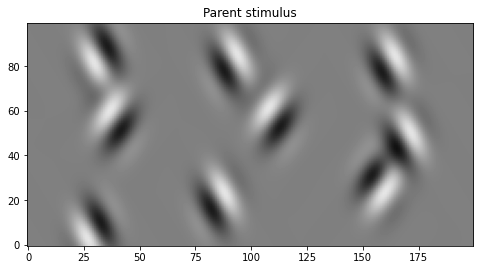

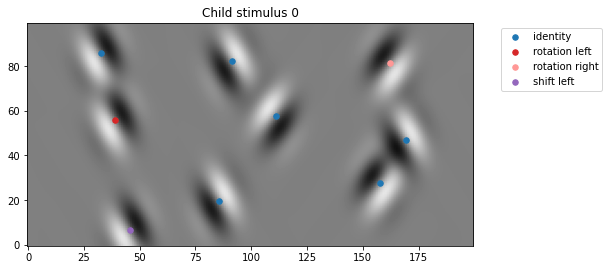

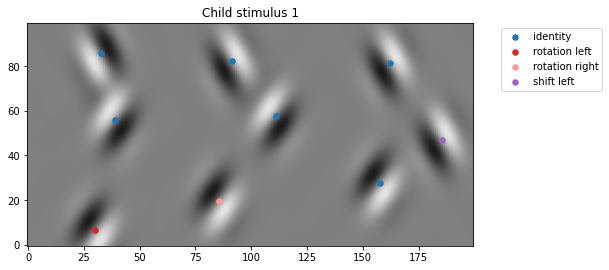

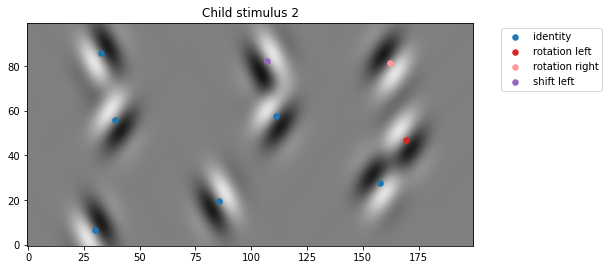

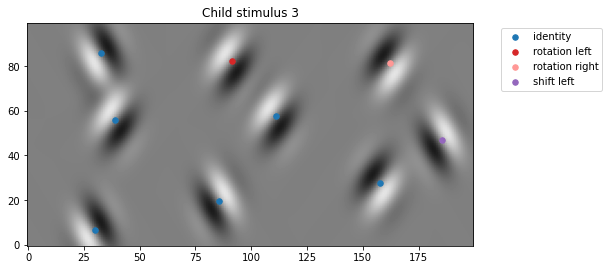

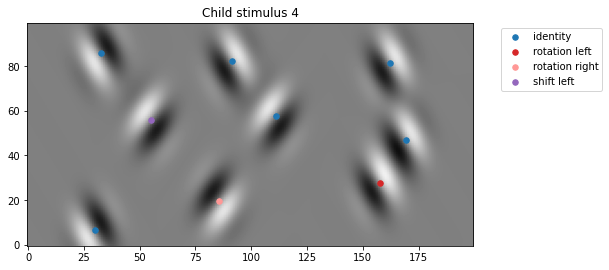

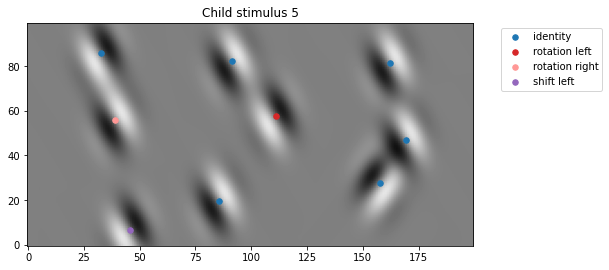

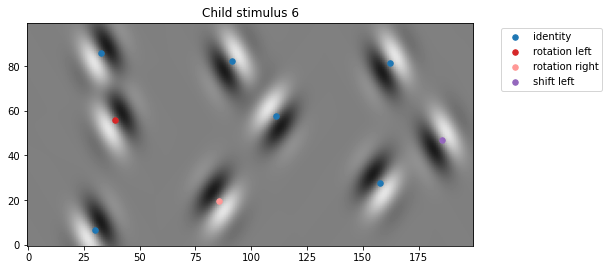

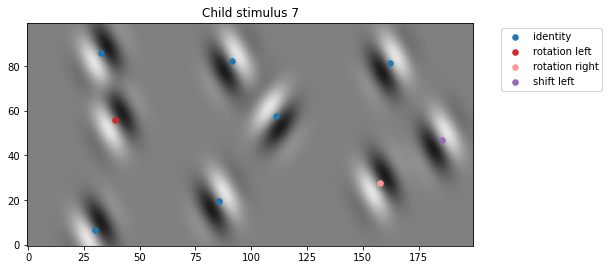

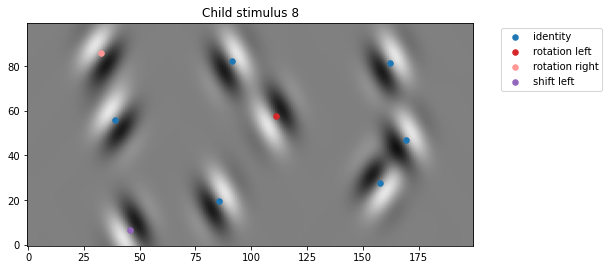

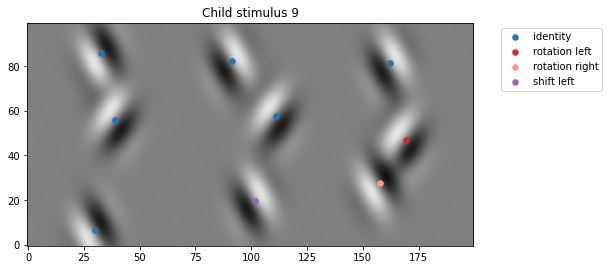

In [7]:
# Plot parent
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
# ax.axis('off')
ax.set_title('Parent stimulus')

# Plot children 
transform_names = ['identity','rotation left','rotation right','shift left','shift right']
all_cols = vis.prep_cmap_discrete('tab20')
transform_cols = [all_cols[0], all_cols[6],all_cols[7], all_cols[8],all_cols[9]]

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.3,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

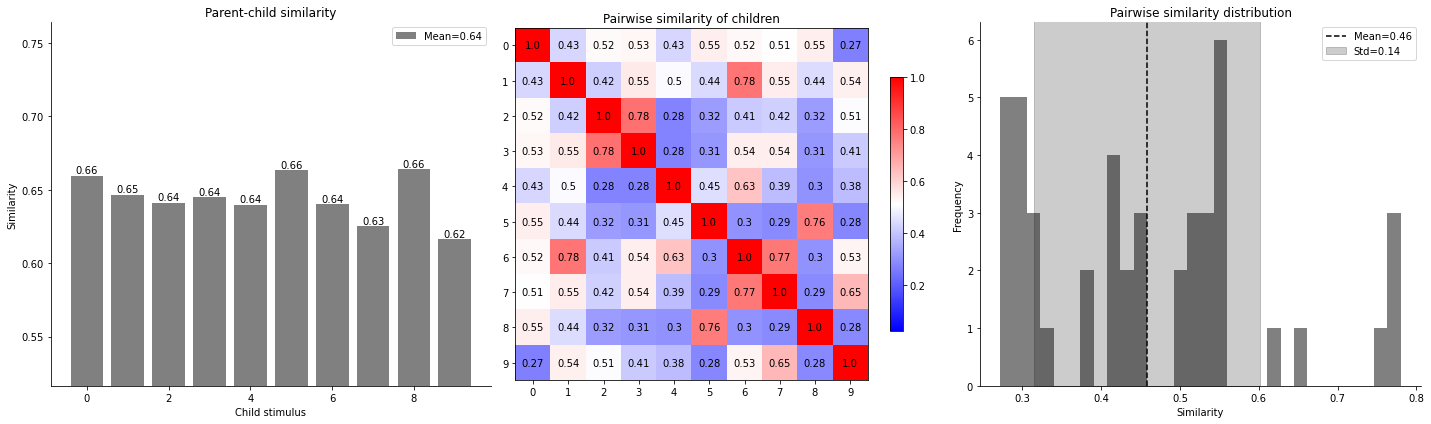

In [8]:
# Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)

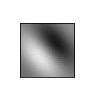

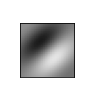

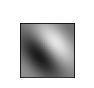

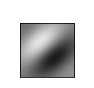

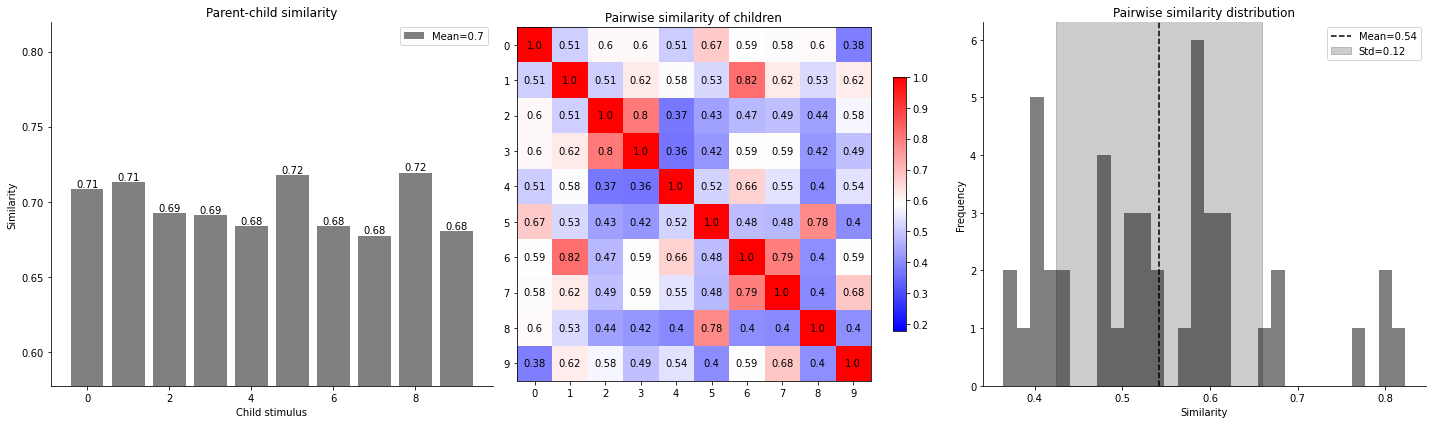

In [9]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)

vec_children = np.stack(im_children)
vec_parent = im_parent[None,:,:]

kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

# Compute parent-children similarity
parent_sim = comp_parent_sim(kmat_parent,kernels_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(kernels_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)

In [12]:
fun_transform=[gs.transform_identity,
               gs.transform_rotate_left,
               gs.transform_rotate_right,
            #    gs.transform_shift_left,
               gs.transform_shift_right]
p_rotate = 0.8
prob_transform = [1-p_rotate] + [p_rotate/(len(fun_transform)-1)]*(len(fun_transform)-1)

# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=10,fun_transform=fun_transform,prob_transform=prob_transform,mode='fixed')

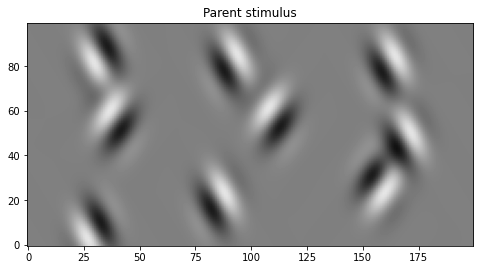

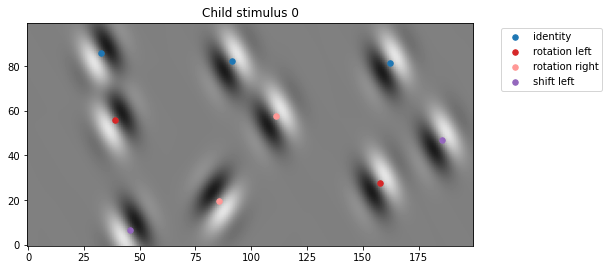

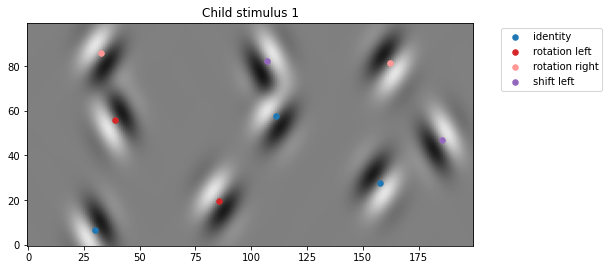

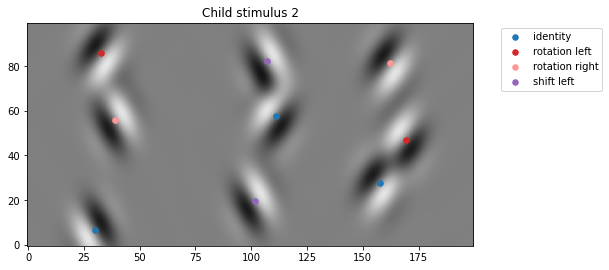

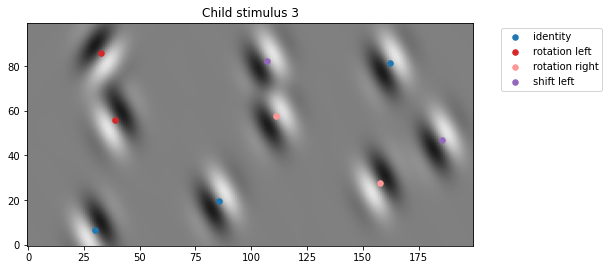

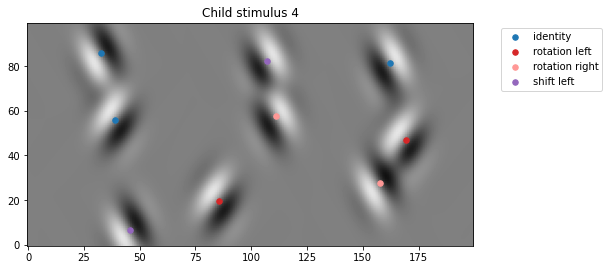

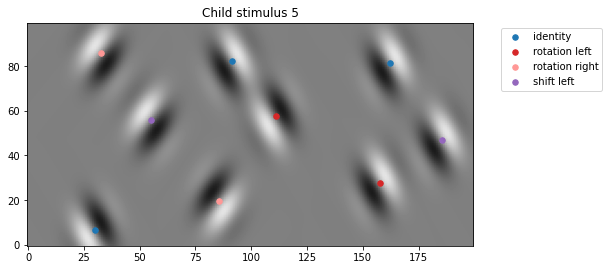

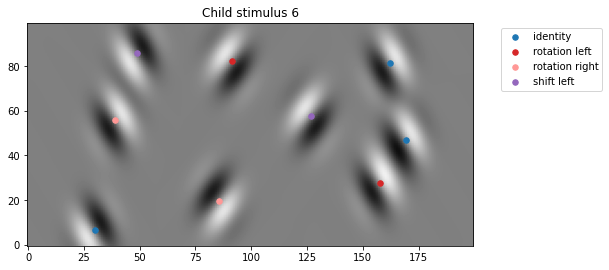

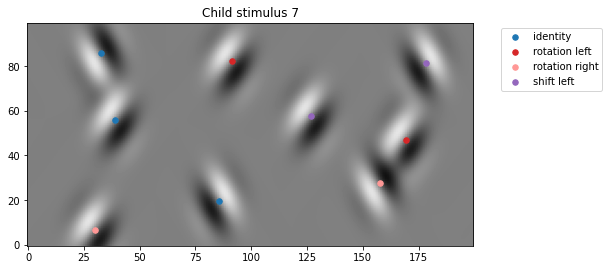

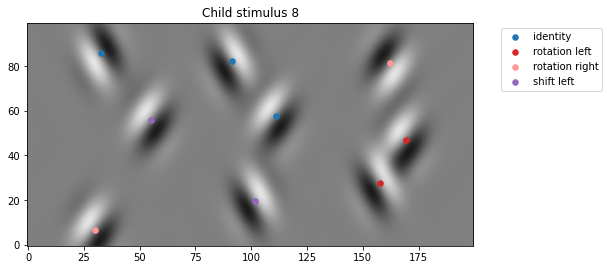

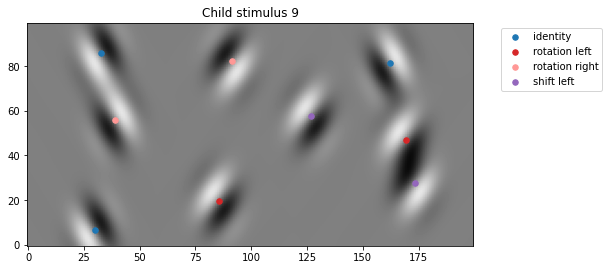

In [13]:
# Plot parent
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
# ax.axis('off')
ax.set_title('Parent stimulus')

# Plot children 
transform_names = ['identity','rotation left','rotation right','shift left','shift right']
all_cols = vis.prep_cmap_discrete('tab20')
transform_cols = [all_cols[0], all_cols[6],all_cols[7], all_cols[8],all_cols[9]]

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.3,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

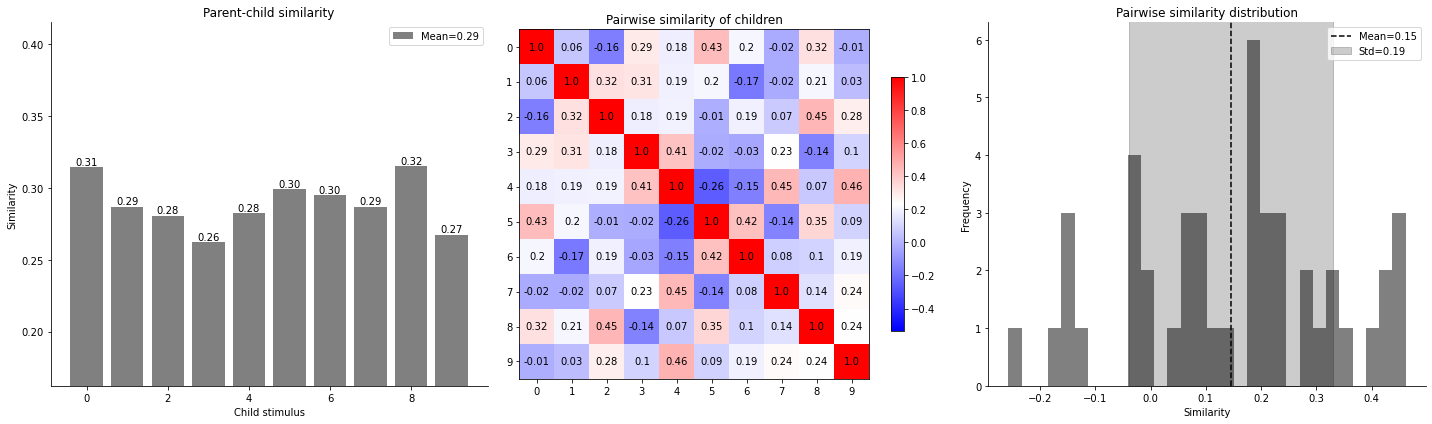

In [14]:
# Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)


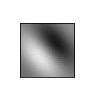

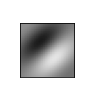

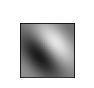

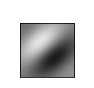

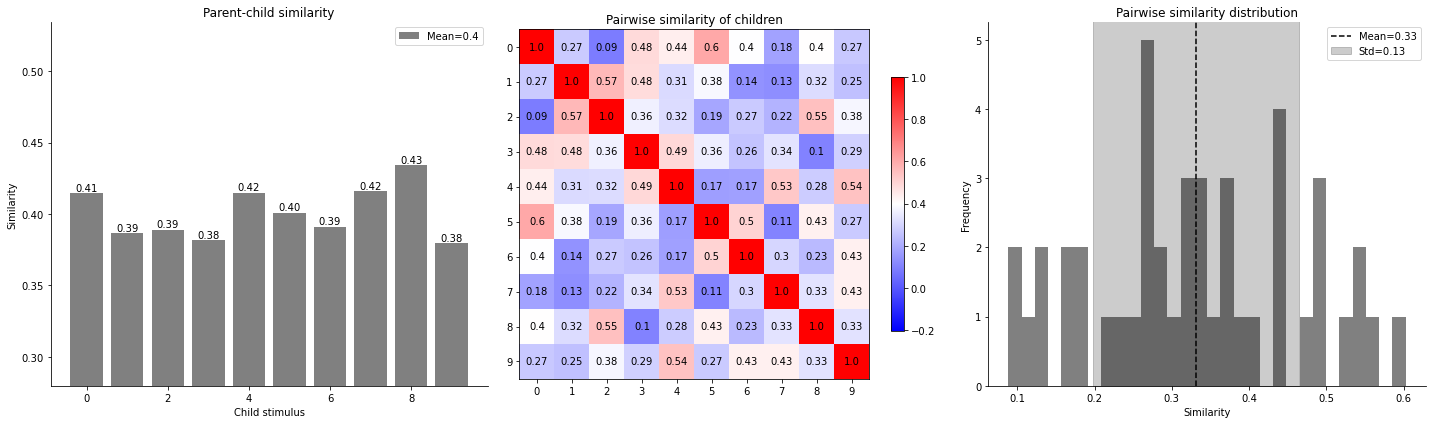

In [15]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=8,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)

vec_children = np.stack(im_children)
vec_parent = im_parent[None,:,:]

kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

# Compute parent-children similarity
parent_sim = comp_parent_sim(kmat_parent,kernels_children)

# Compute pairwise similarity
pairwise_sim = comp_pairwise_sim(kernels_children)

# Plot parent and pairwise similarity
plot_sim(parent_sim, pairwise_sim)

# Parent-child images with different level of kernel activation

In [13]:
gabor_orient = 0.714197
gabor_diff = np.linspace(0,np.pi/2,5)

In [ ]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=gabor_orient-gabor_diff[i],gabor_num=(4,4))

df_parent = pd.DataFrame(dict(zip(gs.dim_names,[parent[i,:] for i in range(parent.shape[0])])))
df_parent

In [ ]:
fun_transform=[gs.transform_identity,
               gs.transform_rotate_left,
               gs.transform_rotate_right,
               gs.transform_shift_left,
               gs.transform_shift_right]
p_rotate = 0.8
prob_transform = [1-p_rotate] + [p_rotate/(len(fun_transform)-1)]*(len(fun_transform)-1)

# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=10,fun_transform=fun_transform,prob_transform=prob_transform)

# Removing sources of noise

## Feature to pixel: remove noise

In [20]:
def comp_sim_precision(parent,im_parent,plot=True):
    transform_names = ['identity','rotation']
    transform_cols = ['blue','red']
    
    prob_transform_all = [[0,1],[1,0],[0.5,0.5]]    
    all_parent_sim = []
    for i in range(len(prob_transform_all)):
        children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=prob_transform_all[i])

        im_children = []
        for i in range(len(children)):
            im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1) #,add_eps=0)
            im_children.append(im_child)  

            f,ax = plt.subplots(1,1,figsize=(8,16))
            ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
            ax.axis('off')
            # Plot type of transform for each Gabor
            # for j in range(len(set_transform[i])):
            #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
            #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
            #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
            # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
            # ax.set_title(f'Child stimulus {i}')    

        parent_sim = comp_parent_sim(im_parent,im_children)
        print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')
        all_parent_sim.append(parent_sim[0])
    
    t_rotate180 = lambda x: gs.transform_rotate_right(x,rad=np.pi)
    children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,t_rotate180],prob_transform=[0,1])
    im_children = []
    for i in range(len(children)):
        im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
        im_children.append(im_child)  

        f,ax = plt.subplots(1,1,figsize=(8,16))
        ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
        ax.axis('off')
        # Plot type of transform for each Gabor
        # for j in range(len(set_transform[i])):
        #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
        # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
        # ax.set_title(f'Child stimulus {i}')    

    parent_sim = comp_parent_sim(im_parent,im_children)
    print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')
    all_parent_sim.append(parent_sim[0])

    

    return all_parent_sim

Pixel-based similarity between child and parent: 4.912562607034517e-17
Pixel-based similarity between child and parent: 1.0000000000000002
Pixel-based similarity between child and parent: 0.49999999999999994
Pixel-based similarity between child and parent: -1.0000000000000002


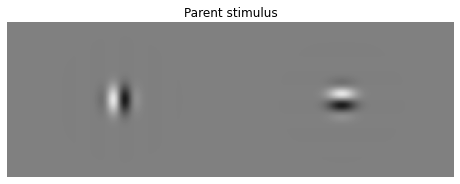

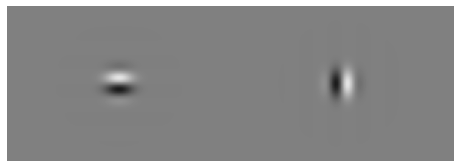

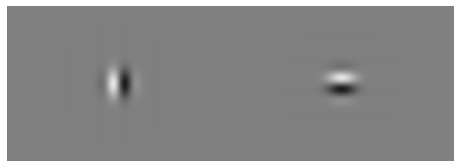

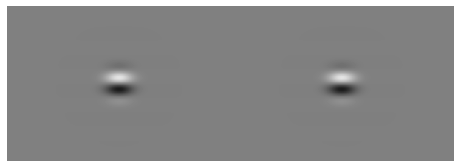

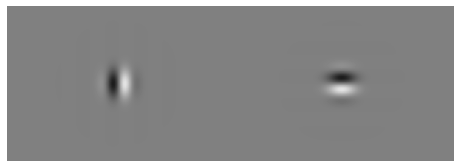

In [21]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(2,1),fixed_freq=0.06)#,adj_w=False,adj_f=True,alph_adj=3)
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

aps = comp_sim_precision(parent,im_parent)

Pixel-based similarity between child and parent: 4.078757264202326e-15
Pixel-based similarity between child and parent: 1.0000000000000002
Pixel-based similarity between child and parent: 0.3749999886639083
Pixel-based similarity between child and parent: -0.9999999999999999


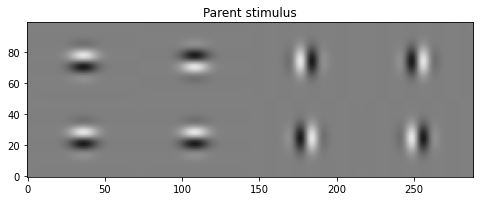

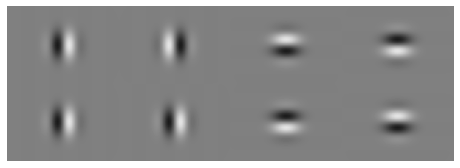

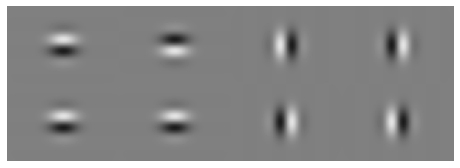

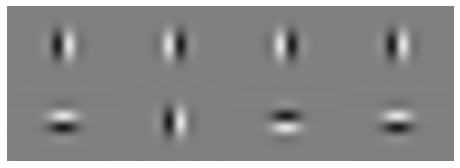

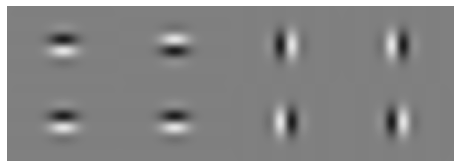

In [22]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(4,2),fixed_freq=0.06)#,adj_w=False,adj_f=True,alph_adj=3)
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
# ax.axis('off')
ax.set_title('Parent stimulus')

aps = comp_sim_precision(parent,im_parent)

Pixel-based similarity between child and parent: 1.6189317216939778e-17


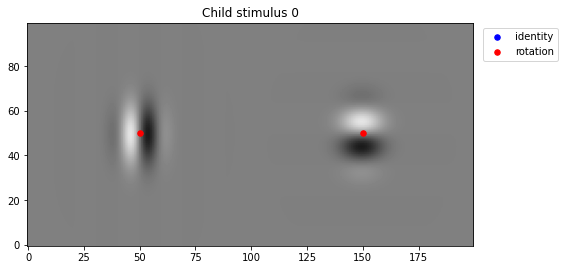

In [50]:
# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=[0,1])

# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

    # Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')

Pixel-based similarity between child and parent: 0.49999999999999967


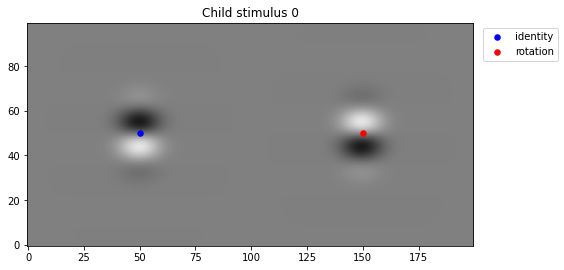

In [51]:
# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=[0.5,0.5])

# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

    # Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')

Pixel-based similarity between child and parent: 1.0000000000000002


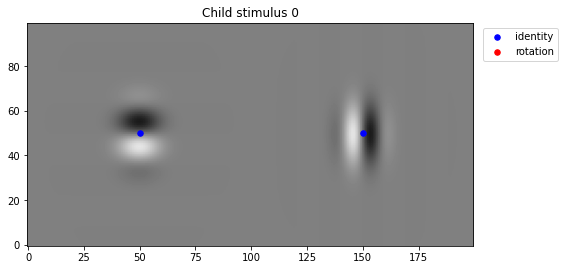

In [52]:
# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=[1,0])

# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

    # Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')

Pixel-based similarity between child and parent: -1.0000000000000002


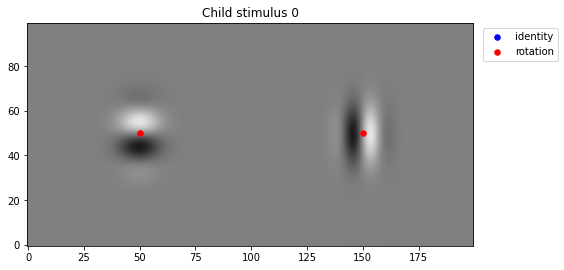

In [53]:
# Generate child stimuli
t_rotate180 = lambda x: gs.transform_rotate_right(x,rad=np.pi)
children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,t_rotate180],prob_transform=[0,1])

# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

    # Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')

## Feature to kernel: remove noise

In [23]:
t_rotate180 = lambda x: gs.transform_rotate_right(x,rad=np.pi)

In [24]:
def comp_sim_precision_kernel(parent,im_parent):
    # transform_names = ['identity','rotation']
    # transform_cols = ['blue','red']

    k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=4,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
    
    vec_parent = im_parent[None,:,:]
    kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()

    parent2 = parent.copy()
    parent2[0,:] += 0.5*np.pi
    im_parent2, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent2,resolution=100,magn=1)
    vec_parent2 = im_parent2[None,:,:]
    kmat_parent2 = compute_kernel_matrix((vec_parent2,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_parent2,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    ax.set_title('Parent stimulus (rotated)')

    prob_transform_all = [[0,1],[1,0],[0.5,0.5]]    
    all_parent_sim = []; all_parent_sim2 = []
    for i in range(len(prob_transform_all)):
        print(f'Transform {i}: {prob_transform_all[i]}')
        children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=prob_transform_all[i],mode='fixed')

        im_children = []
        for j in range(len(children)):
            im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j],resolution=100,magn=1) #,add_eps=0)
            im_children.append(im_child)  

            f,ax = plt.subplots(1,1,figsize=(8,16))
            ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
            ax.axis('off')
            ax.set_title(f'transform {i}')
            # Plot type of transform for each Gabor
            # for j in range(len(set_transform[i])):
            #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
            #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
            #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
            # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
            # ax.set_title(f'Child stimulus {i}')    

        vec_children = np.stack(im_children)
        kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
        kernels_children = [kmat_children[:,j] for j in range(kmat_children.shape[1])]
        parent_sim = comp_parent_sim(kmat_parent,kernels_children)
        print(f'Kernel-based similarity (transform {i}): {parent_sim[0]}')
        all_parent_sim.append(parent_sim[0])

        children2 = children.copy()
        for j in range(len(children2)):
            children2[j][0,:] += 0.5*np.pi
    
        im_children2 = []
        for j in range(len(children2)):
            im_child2, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children2[j],resolution=100,magn=1) #,add_eps=0)
            im_children2.append(im_child2)  

            f,ax = plt.subplots(1,1,figsize=(8,16))
            ax.imshow(im_child2,cmap='gray',vmin=-1,vmax=1,origin='lower')
            ax.axis('off')
            ax.set_title(f'transform {i}, rotated')
            # Plot type of transform for each Gabor
            # for j in range(len(set_transform[i])):
            #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
            #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
            #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
            # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
            # ax.set_title(f'Child stimulus {i}')    

        vec_children2 = np.stack(im_children2)
        kmat_children2 = compute_kernel_matrix((vec_children2,None),k_params,idx=True,conv=True,parallel_k=False)
        kernels_children2 = [kmat_children2[:,j] for j in range(kmat_children2.shape[1])]
        parent_sim2 = comp_parent_sim(kmat_parent2,kernels_children2)
        print(f'Kernel-based similarity (transform {i}, rotated): {parent_sim2[0]}')
        all_parent_sim2.append(parent_sim2[0])
    
    print('Transform 180 degrees')
    t_rotate180 = lambda x: gs.transform_rotate_right(x,rad=np.pi)
    children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,t_rotate180],prob_transform=[0,1])
    im_children = []
    for i in range(len(children)):
        im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
        im_children.append(im_child)  

        f,ax = plt.subplots(1,1,figsize=(8,16))
        ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
        ax.axis('off')
        ax.set_title('transform 180')
        # Plot type of transform for each Gabor
        # for j in range(len(set_transform[i])):
        #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
        # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
        # ax.set_title(f'Child stimulus {i}')    
    vec_children = np.stack(im_children)
    kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
    kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
    parent_sim = comp_parent_sim(kmat_parent,kernels_children)
    print(f'Kernel-based similarity between child and parent: {parent_sim[0]}')
    all_parent_sim.append(parent_sim[0])

    children2 = children.copy()
    for j in range(len(children2)):
        children2[j][0,:] += 0.5*np.pi

    im_children2 = []
    for i in range(len(children2)):
        im_child2, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children2[i],resolution=100,magn=1)
        im_children2.append(im_child2)  

        f,ax = plt.subplots(1,1,figsize=(8,16))
        ax.imshow(im_child2,cmap='gray',vmin=-1,vmax=1,origin='lower')
        ax.axis('off')
        ax.set_title('transform 180, rotated')
        # Plot type of transform for each Gabor
        # for j in range(len(set_transform[i])):
        #     xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        #     yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        #     ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
        # ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
        # ax.set_title(f'Child stimulus {i}')    
    vec_children2 = np.stack(im_children2)
    kmat_children2 = compute_kernel_matrix((vec_children2,None),k_params,idx=True,conv=True,parallel_k=False)
    kernels_children2 = [kmat_children2[:,i] for i in range(kmat_children2.shape[1])]
    parent_sim2 = comp_parent_sim(kmat_parent2,kernels_children2)
    print(f'Kernel-based similarity between child and parent (rotated): {parent_sim2[0]}')
    all_parent_sim.append(parent_sim2[0])

    return all_parent_sim, all_parent_sim2

Transform 0: [0, 1]
Kernel-based similarity (transform 0): 0.12368607370389068
Kernel-based similarity (transform 0, rotated): 0.12368607371113229
Transform 1: [1, 0]
Kernel-based similarity (transform 1): 1.0000000000000002
Kernel-based similarity (transform 1, rotated): 1.0
Transform 2: [0.5, 0.5]
Kernel-based similarity (transform 2): 1.0000000000000002
Kernel-based similarity (transform 2, rotated): 1.0
Transform 180 degrees
Kernel-based similarity between child and parent: 2.93867262041383e-21
Kernel-based similarity between child and parent (rotated): 4.747578338821342e-19


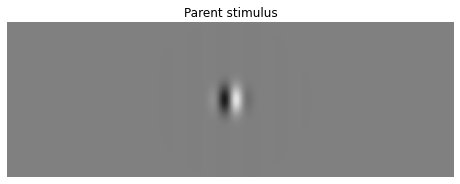

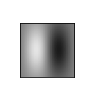

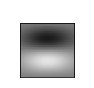

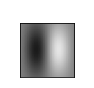

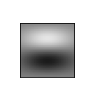

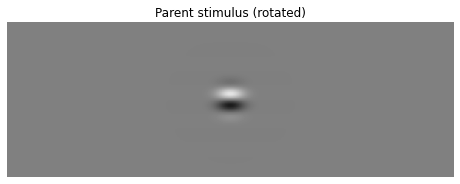

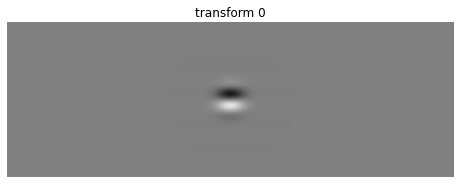

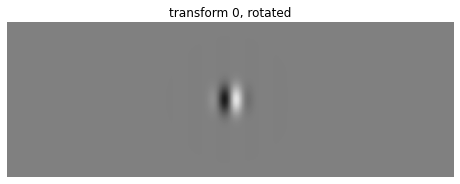

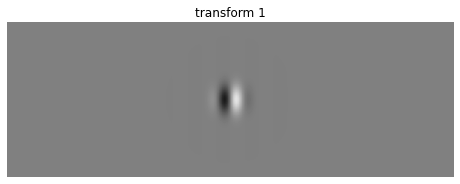

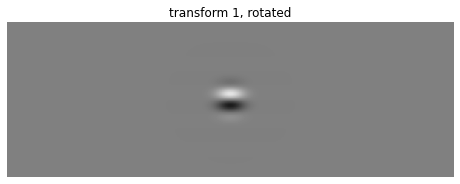

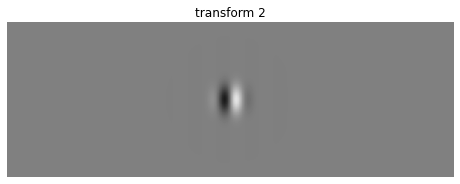

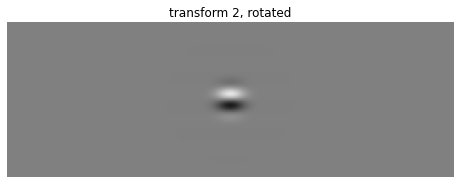

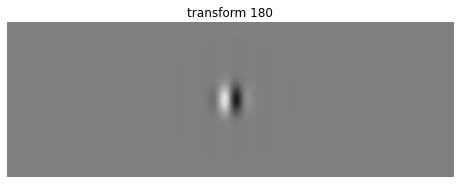

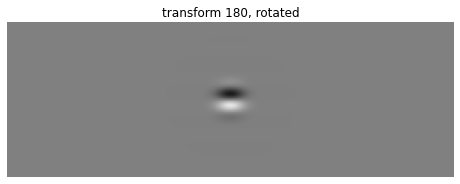

In [26]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(1,1),fixed_freq=0.06)#,adj_w=False,adj_f=True,alph_adj=3)
parent[0,:] = 0
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1,add_eps=0)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

aps, aps2 = comp_sim_precision_kernel(parent,im_parent)

Transform 0: [0, 1]
Kernel-based similarity (transform 0): 0.12283644917118489
Kernel-based similarity (transform 0, rotated): 0.12283644915159808
Transform 1: [1, 0]
Kernel-based similarity (transform 1): 1.0000000000000002
Kernel-based similarity (transform 1, rotated): 1.0
Transform 2: [0.5, 0.5]
Kernel-based similarity (transform 2): 0.5555890948946837
Kernel-based similarity (transform 2, rotated): 0.5661789790011246
Transform 180 degrees
Kernel-based similarity between child and parent: 0.0
Kernel-based similarity between child and parent (rotated): 0.0


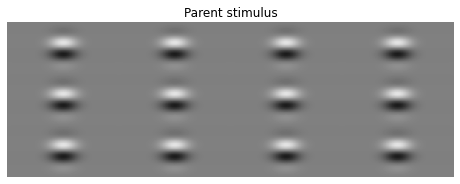

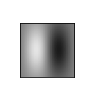

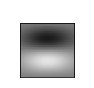

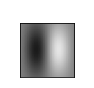

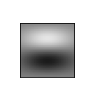

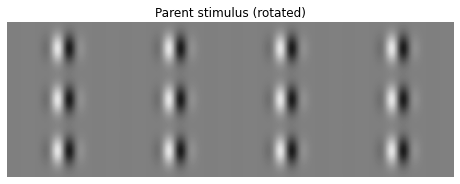

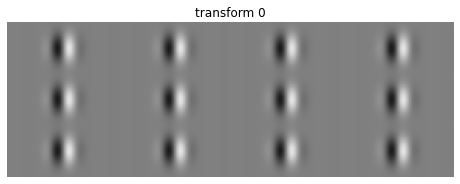

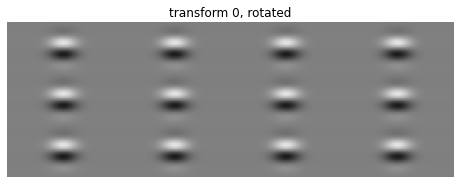

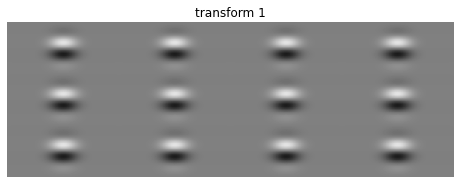

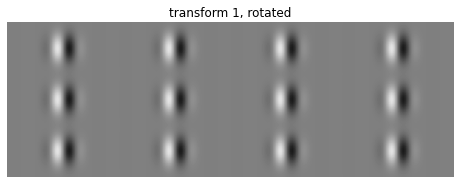

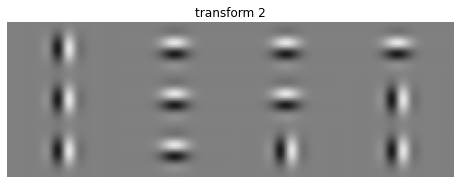

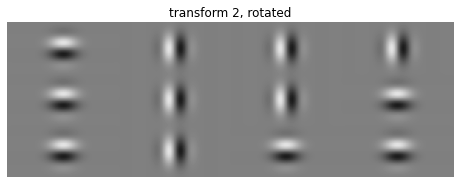

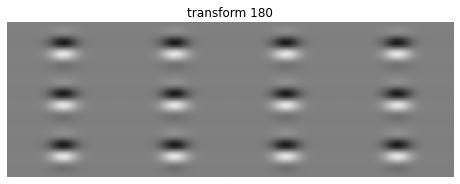

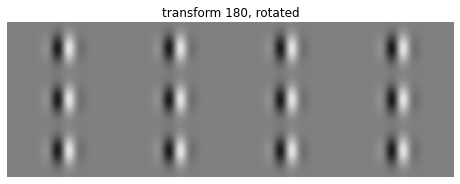

In [16]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(4,3),fixed_freq=0.06)#,adj_w=False,adj_f=True,alph_adj=3)
parent[0,:] = 0.5*np.pi
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

aps = comp_sim_precision_kernel(parent,im_parent)

### Similarity as a function of ksig

Text(0.5, 1.0, 'Parent stimulus')

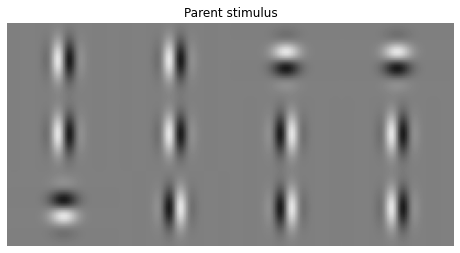

In [75]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(4,3),fixed_freq=0.06)#,adj_w=False,adj_f=True,alph_adj=3)
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

Angle: 0.0
Pixel-based similarity between child and parent: 0.9999999999999999
Kernel-based similarity between child and parent: 1.0
Angle: 0.6981317007977318
Pixel-based similarity between child and parent: 0.5848223956011718
Kernel-based similarity between child and parent: 0.5147650868516761
Angle: 1.3962634015954636
Pixel-based similarity between child and parent: 0.08816042573626126
Kernel-based similarity between child and parent: 0.03791905840442385
Angle: 2.0943951023931953
Pixel-based similarity between child and parent: -0.30051476277956174
Kernel-based similarity between child and parent: 0.020910547867235545
Angle: 2.792526803190927
Pixel-based similarity between child and parent: -0.8726388612093845
Kernel-based similarity between child and parent: 0.00018502057816569418
Angle: 3.490658503988659
Pixel-based similarity between child and parent: -0.8726559001015055
Kernel-based similarity between child and parent: 6.954684178063105e-05
Angle: 4.1887902047863905
Pixel-based s

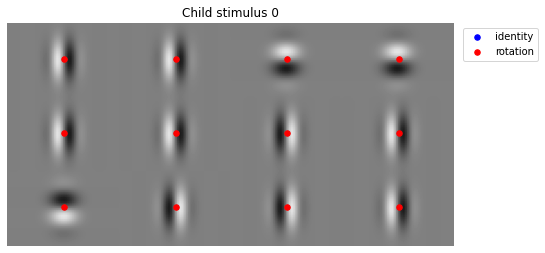

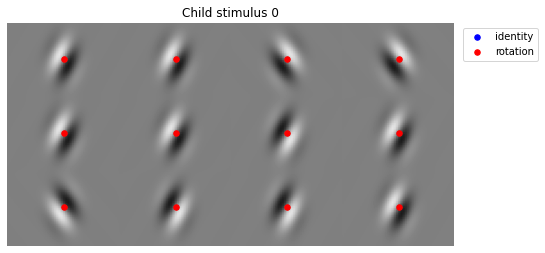

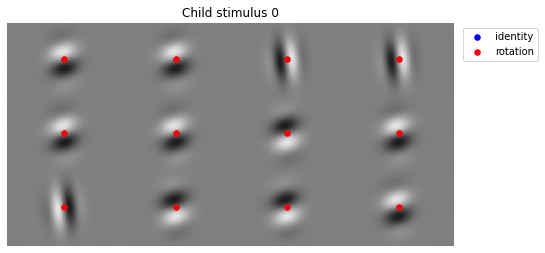

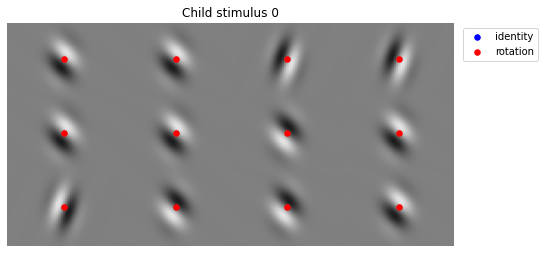

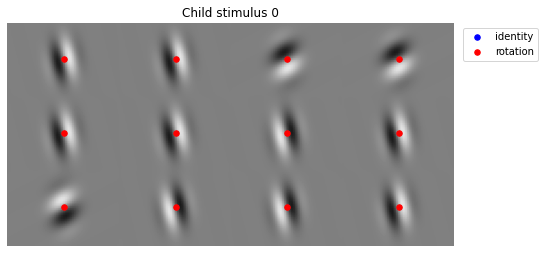

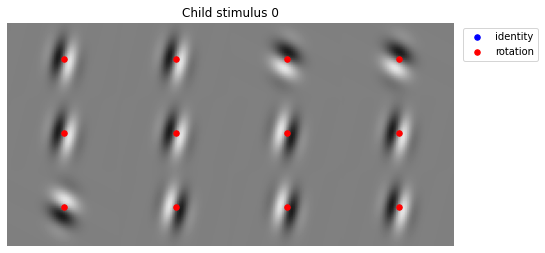

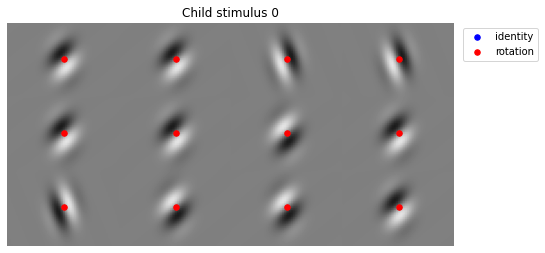

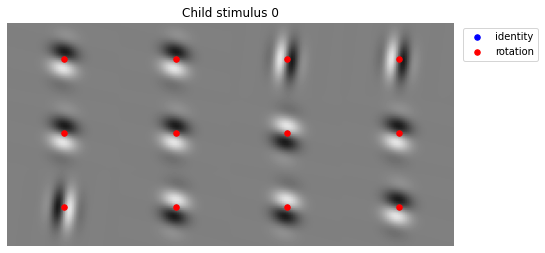

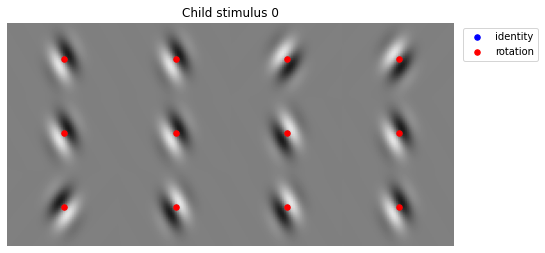

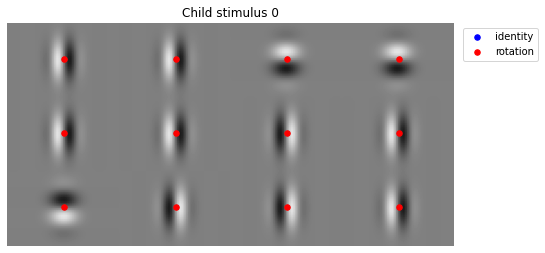

In [121]:
all_pixel_sim = []
all_kernel_sim = []
all_angles = np.linspace(0,2*np.pi,10)

for i, ti in enumerate(all_angles):
    t_rotate_ti = lambda x: gs.transform_rotate_right(x,rad=ti)
    print(f'Angle: {ti}')
    children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,t_rotate_ti],prob_transform=[0,1])

    # Plot children 
    transform_names = ['identity','rotation']
    transform_cols = ['blue','red']

    im_children = []
    for i in range(len(children)):
        # Plot child
        im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1,add_eps=0)
        im_children.append(im_child)
        f,ax = plt.subplots(1,1,figsize=(8,16))
        ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
        ax.axis('off')
        # Plot type of transform for each Gabor
        for j in range(len(set_transform[i])):
            xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
            yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
            ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
        ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
        ax.set_title(f'Child stimulus {i}')    

    parent_sim = comp_parent_sim(im_parent,im_children)
    print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')
    all_pixel_sim.append(parent_sim[0])

    # Create simple cell kernel novelty model
    k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=0.98,kcenter=1,cdens=10,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=False)

    vec_children = np.stack(im_children)
    vec_parent = im_parent[None,:,:]

    kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
    kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
    kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

    # Compute parent-children similarity
    parent_sim = comp_parent_sim(kmat_parent,kernels_children)
    print(f'Kernel-based similarity between child and parent: {parent_sim[0]}')
    all_kernel_sim.append(parent_sim[0])

[]
First angle with <=0 pixel similarity: 0.6666666666666666
First angle with <=zero kernel similarity: nan


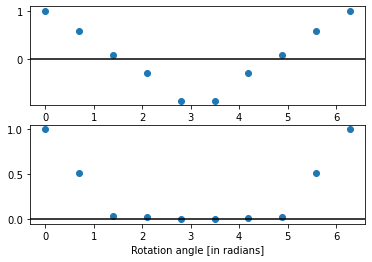

In [ ]:
f,ax = plt.subplots(2,1)
ax[0].plot(all_angles,all_pixel_sim,'o')
ax[0].axhline(y=0,c='k')
ax[0].set_xlabel('Rotation angle [in radians]')

ax[1].plot(all_angles,all_kernel_sim,'o')
ax[1].axhline(y=0,c='k')
ax[1].set_xlabel('Rotation angle [in radians]')
fp = np.where(np.array(all_pixel_sim)<=0)[0]
fk = np.where(np.array(all_kernel_sim)<=0)[0]
print(fk)
print(f'First angle with <=0 pixel similarity: {all_angles[fp][0]/np.pi if len(fp)>0 else np.NaN}')
print(f'First angle with <=zero kernel similarity: {all_angles[fk][0]/np.pi if len(fk)>0 else np.NaN}')
# print(all_kernel_sim)
# print(all_angles)

### Activations of most responsive (centered) kernels

Pixel-based similarity between child and parent: 0.9999999999999999
Kernel-based similarity between child and parent: 1.0


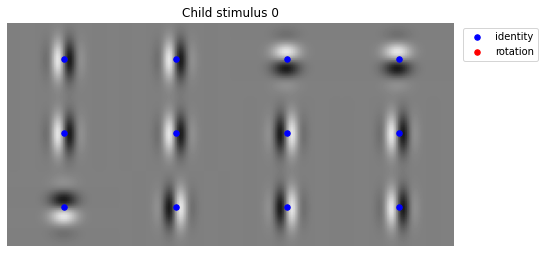

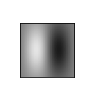

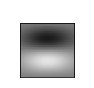

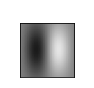

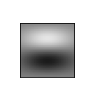

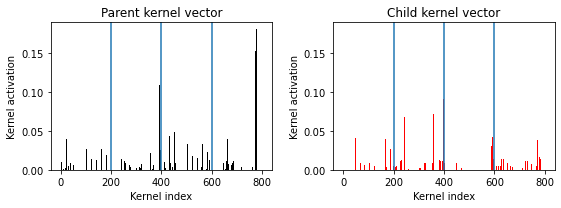

In [82]:
# Generate child stimuli
# children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,t_rotate180],prob_transform=[0,1])
children, set_transform = gs.generate_teststim_children(parent,num_child=1,fun_transform=[gs.transform_identity,gs.transform_rotate_right],prob_transform=[1,0])

# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1,add_eps=0)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,16))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*200/260
        yloc = (children[i][5,set_transform[i][j]] + 20)*100/90
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

    # Compute pixel-based similarity to parent
parent_sim = comp_parent_sim(im_parent,im_children)

print(f'Pixel-based similarity between child and parent: {parent_sim[0]}')

# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=10,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)

vec_children = np.stack(im_children)
vec_parent = im_parent[None,:,:]

kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

# Compute parent-children similarity
parent_sim = comp_parent_sim(kmat_parent,kernels_children)
print(f'Kernel-based similarity between child and parent: {parent_sim[0]}')

f,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].bar(np.arange(kmat_parent.shape[0]),kmat_parent,color='k')
ax[1].bar(np.arange(kmat_children.shape[0]),kmat_children[:,0],color='r')
xlines = [kmat_parent.shape[0]/4*(i+1) for i in range(3)]
for x in xlines:
    ax[0].axvline(x=x)
    ax[1].axvline(x=x)
ax[0].set_title('Parent kernel vector')
ax[1].set_title('Child kernel vector')
ax[0].set_xlabel('Kernel index')
ax[1].set_xlabel('Kernel index')
ax[0].set_ylabel('Kernel activation')
ax[1].set_ylabel('Kernel activation')
f.tight_layout()

Reference gabor dimensions: (24, 24)
Number of kernel centers: (10, 20)
Convolution dimensions: (10, 20)


(-0.5, 19.5, -0.5, 9.5)

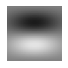

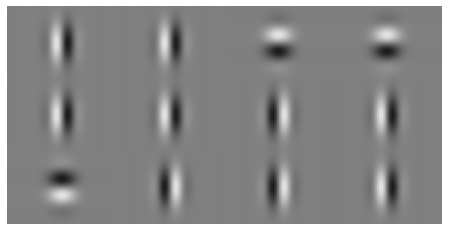

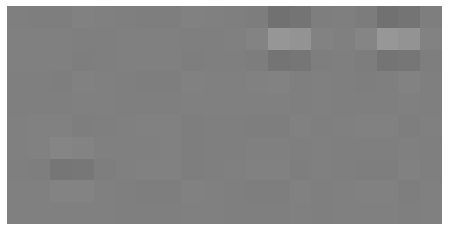

In [77]:
from scipy import ndimage as ndi

k = k_params['ref_gabors_im'][3]
kdim = k.shape
krad_x = int(kdim[0]/2)
krad_y = int(kdim[1]/2)
print(f'Reference gabor dimensions: {kdim}')

cdens = 10
im_dim = (200,100)
kc_xl = np.arange(0,im_dim[0],cdens)
kc_yl = np.arange(0,im_dim[1],cdens)
kc_xg, kc_yg = np.meshgrid(kc_xl,kc_yl)
kc_x = kc_xg.flatten()
kc_y = kc_yg.flatten()
print(f'Number of kernel centers: {kc_xg.shape}')

norm = (np.linalg.norm(im_parent.flatten()) * np.linalg.norm(k.flatten()))
conv = ndi.convolve(im_parent, k, mode='constant')[::cdens,::cdens] / norm 
print(f'Convolution dimensions: {conv.shape}')

f,ax = plt.subplots(1,1,figsize=(1,1))
ax.imshow(k,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
f,ax = plt.subplots(1,1,figsize=(8,4))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
f,ax = plt.subplots(1,1,figsize=(8,4))
ax.imshow(conv,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
# plt.imshow(im_parent[int(kc_y[i]-krad_y):int(kc_y[i]+krad_y),int(kc_x[i]-krad_x):int(kc_x[i]+krad_x)],cmap='gray',vmin=-1,vmax=1,origin='lower')

In [78]:
threshold = 0.1
peak_parent = np.where(kmat_parent>threshold)[0]
peak_child  = np.where(kmat_children[:,0]>threshold)[0]
print(f'Parent peak kernels: {peak_parent}')
print(f'Child peak kernels: {peak_child}')

Parent peak kernels: [392 397 772 773 777 778]
Child peak kernels: [372 373 377 378 792 797]


In [79]:
print(k_params['ref_gabors'])

   orientation     phase  frequency     width  x-position  y-position
0     0.000000 -1.570796       0.04  8.333333         0.0         0.0
1     1.570796 -1.570796       0.04  8.333333         0.0         0.0
2     0.000000  1.570796       0.04  8.333333         0.0         0.0
3     1.570796  1.570796       0.04  8.333333         0.0         0.0


In [80]:
from scipy import ndimage as ndi

for ii in range(4):
    igabor = ii
    k = k_params['ref_gabors_im'][igabor]
    kdim = k.shape
    krad_x = int(kdim[0]/2)
    krad_y = int(kdim[1]/2)
    print(f'Reference gabor dimensions: {kdim}')

    cdens = 10
    im_dim = (200,100)
    kc_xl = np.arange(0,im_dim[0],cdens)
    kc_yl = np.arange(0,im_dim[1],cdens)
    kc_xg, kc_yg = np.meshgrid(kc_xl,kc_yl)
    kc_x = kc_xg.flatten()
    kc_y = kc_yg.flatten()
    print(f'Number of kernel centers: {kc_xg.shape}')
    kc_xl_im = np.arange(0,im_dim[0])[::cdens]
    kc_yl_im = np.arange(0,im_dim[1])[::cdens]
    # print(kc_xl_im)
    # print(kc_yl_im)
    kc_xg_im, kc_yg_im = np.meshgrid(kc_xl_im,kc_yl_im)
    kc_x_im = kc_xg_im.flatten()
    kc_y_im = kc_yg_im.flatten()
    # print(kc_xg_im.shape)
    # print(kc_x_im)
    # print(kc_y_im)

    # Plot parent image, reference gabor, and convolution
    # f,ax = plt.subplots(1,1,figsize=(1,1))
    # ax.imshow(k,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # f,ax = plt.subplots(1,1,figsize=(8,4))
    # ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # f,ax = plt.subplots(1,1,figsize=(8,4))
    # ax.imshow(conv,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')

    print(parent.shape)
    pg1 = parent[4:,0]
    print(pg1)
    pg1_x = int((pg1[0] + 130)*200/260)
    pg1_y = int((pg1[1] + 20)*100/90)
    # pg2 = parent[4:,1]
    # print(pg2)
    # pg2_x = int((pg2[0] + 130)*200/260)
    # pg2_y = int((pg2[1] + 20)*100/90)

    print([pg1_x,pg1_y])
    # print([pg2_x,pg2_y])

    # Get kernels that overlap exactly with gabors in parent image
    i1 = list(set(np.where(kc_x_im==pg1_x)[0]).intersection(set(np.where(kc_y_im==pg1_y)[0])))[0]
    print(f'Left gabor in parent image: conv. center {i1} in pixel position ({kc_x[i1]},{kc_y[i1]}).')

    # i2 = list(set(np.where(kc_x_im==150)[0]).intersection(set(np.where(kc_y_im==50)[0])))[0]
    # print(f'Right gabor in parent image: conv. center {i2} in pixel position ({kc_x[i2]},{kc_y[i2]}).')

    # Compute activation of reference gabor
    im1 = im_parent[int(kc_y[i1]-krad_y):int(kc_y[i1]+krad_y),int(kc_x[i1]-krad_x):int(kc_x[i1]+krad_x)]
    # im2 = im_parent[int(kc_y[i2]-krad_y):int(kc_y[i2]+krad_y),int(kc_x[i2]-krad_x):int(kc_x[i2]+krad_x)]

    norm = (np.linalg.norm(im_parent.flatten()) * np.linalg.norm(k.flatten()))
    conv1 = np.dot(im1.flatten(),k.flatten()) / norm 
    # conv2 = np.dot(im2.flatten(),k.flatten()) / norm
    conv1p = np.dot(im1.flatten(),k.flatten()) / (np.linalg.norm(im1.flatten()) * np.linalg.norm(k.flatten()))
    # conv2p = np.dot(im2.flatten(),k.flatten()) / (np.linalg.norm(im2.flatten()) * np.linalg.norm(k.flatten()))
    print(f'Activation of kernel {i1} to left gabor: {np.round(conv1,15)}.')
    # print(f'Activation of kernel {i2} to left gabor: {np.round(conv2,15)}.')

    print(f'Activation of kernel {i1} to left gabor (individual norm.): {np.round(conv1p,15)}.')
    # print(f'Activation of kernel {i2} to left gabor (individual norm.): {np.round(conv2p,15)}.')


    # Plot parent image patches + reference gabor
    f,ax = plt.subplots(1,1,figsize=(4,4))
    ax.imshow(im1,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    ax.set_title('Parent stimulus (left gabor)')

    # f,ax = plt.subplots(1,1,figsize=(4,4))
    # ax.imshow(im2,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # ax.set_title('Parent stimulus (right gabor)')

    f,ax = plt.subplots(1,1,figsize=(4,4))
    ax.imshow(k,cmap='gray',vmin=-1,vmax=1,origin='lower')
    ax.axis('off')
    ax.set_title(f'Reference gabor {igabor}')

Reference gabor dimensions: (24, 24)
Number of kernel centers: (10, 20)
(6, 12)
[-97.5  -5. ]
[25, 16]


IndexError: list index out of range

# Testing denoised similarity matrices

## Exact overlap

In [10]:
num_child = 10

# Generate children
init_child_full, vals_gabor = gs.generate_teststim_parent(gs.dim_ranges_rad,n_orient=4,init_orient=0,fixed_freq=0.06,gabor_num=(4,1))
print(vals_gabor)
# print(init_child_full)

# vals_gabor_child = np.unique(init_child_full[0,:])
# if len(vals_gabor_child) < 2:
#     vals_gabor_child.append(np.random.choice(vals_gabor[np.where(vals_gabor!=vals_gabor_child[0])]))
# print(vals_gabor_child)

print(vals_gabor[0].shape)
children, overlap = gs.generate_teststim_iterative_1d(init_child_full,vals_gabor[0],num_child,field_transform=[0],prob_overlap=[0.1],rng=None)

[array([[0.        ],
       [1.57079633],
       [3.14159265],
       [4.71238898]])]
(4, 1)
Required overlap between children is too small to sample additional children. Number of children returned: 4.


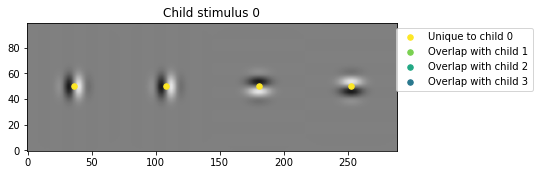

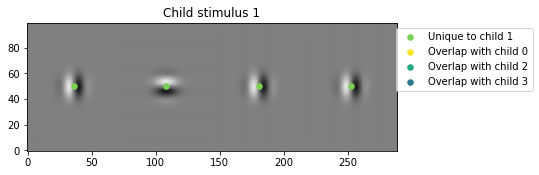

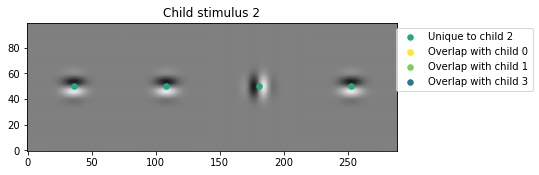

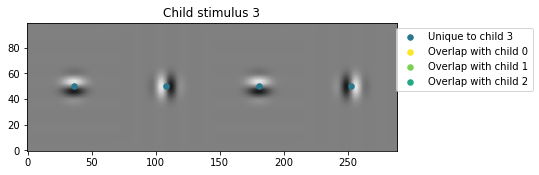

In [29]:
# Plot children
child_colors = vis.prep_cmap('viridis',len(children))

ratio_y_x = (gs.dim_ranges[4][1]-gs.dim_ranges[4][0])/(gs.dim_ranges[5][1]-gs.dim_ranges[5][0])
scale_x = int(np.round(100*ratio_y_x))/260
scale_y = 100/90

im_children = []
f_children = []
ax_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1,add_eps=0)
    im_children.append(im_child)

    f,ax = plt.subplots(1,1,figsize=(8,8*ratio_y_x))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    ax.set_title(f'Child stimulus {i}')
    f_children.append(f)
    ax_children.append(ax)

    # Plot all Gabors of current child i into plot of child i
    xloc_i = (children[i][4,:] + 130) * scale_x # 100*ratio_y_x pixel covering 260 degrees
    yloc_i = (children[i][5,:] + 20) * scale_y # 100 pixel covering 90 degrees
    ax.scatter(xloc_i,yloc_i,s=30,color=child_colors[i],label=f'Unique to child {i}') 

    # Plot overlap between currently plotted image i and previous images j 
    for j in range(len(overlap[i])):
        xloc_same = (children[j][4,overlap[i][j]] + 130) * scale_x 
        yloc_same = (children[j][5,overlap[i][j]] + 20) * scale_y 
        ax.scatter(xloc_same,yloc_same,s=30,color=child_colors[j],label=f'Overlap with child {j}') # Plot overlap with child j into plot of current child i
        ax_children[j].scatter(xloc_same,yloc_same,s=30,color=child_colors[i],label=f'Overlap with child {i}') # Plot overlap with current child i into plot of child j
    
for i in range(len(f_children)):
    ax_children[i].legend(bbox_to_anchor=(1.38,1),loc='upper right')
    f_children[i].tight_layout()

4
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[0. 0. 0. 0. 0. 0.]


(0.0, 1.0)

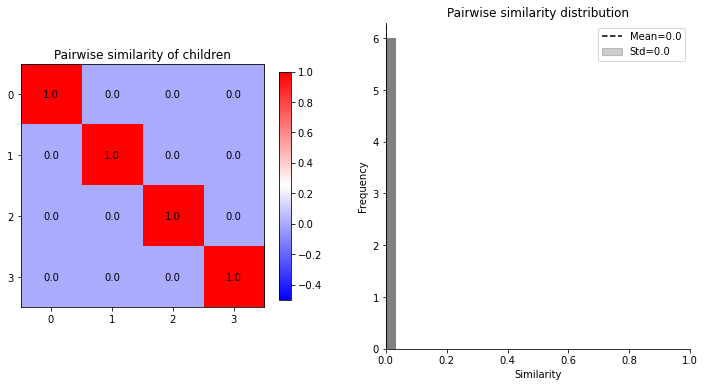

In [30]:
# Compute feature-based pairwise similarity
df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
print(len(df_children[0]))

sim_features = ['orientation']
list_children_features = [df_children[i][sim_features].to_numpy() for i in range(len(df_children))]  

pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([0,1])

[[ 1.   -0.25 -0.25 -0.5 ]
 [-0.25  1.   -0.5  -0.25]
 [-0.25 -0.5   1.   -0.25]
 [-0.5  -0.25 -0.25  1.  ]]
[-0.25 -0.25 -0.5  -0.5  -0.25 -0.25]


(-1.0, 1.0)

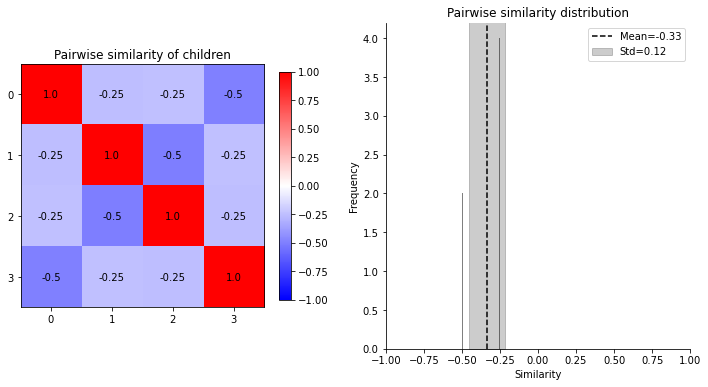

In [31]:
# Compute pixel-based pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot pixel-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

   orientation     phase  frequency     width  x-position  y-position
0     0.000000 -1.570796       0.04  8.333333         0.0         0.0
1     1.570796 -1.570796       0.04  8.333333         0.0         0.0
2     0.000000  1.570796       0.04  8.333333         0.0         0.0
3     1.570796  1.570796       0.04  8.333333         0.0         0.0
(4, 100, 289)
4
(7300,)
[[1.         0.09266209 0.09286557 0.06184244]
 [0.09266209 1.         0.06184259 0.09266209]
 [0.09286557 0.06184259 1.         0.09286557]
 [0.06184244 0.09266209 0.09286557 1.        ]]
[0.09266209 0.09286557 0.06184244 0.06184259 0.09266209 0.09286557]


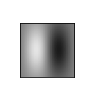

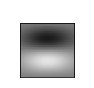

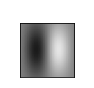

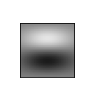

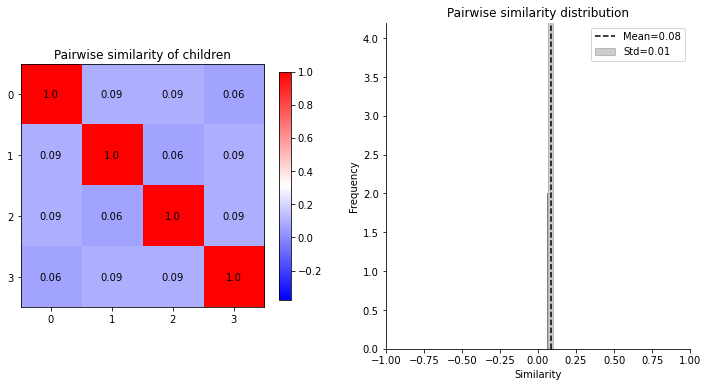

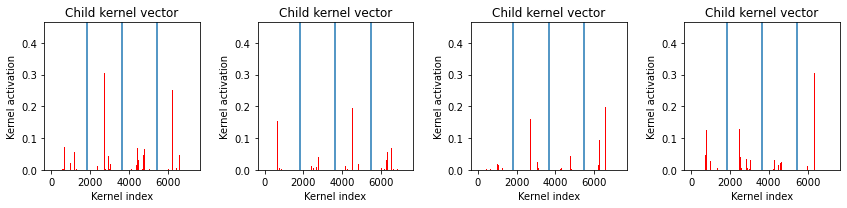

In [32]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=4,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
print(k_params['ref_gabors'])

vec_children = np.stack(im_children)
print(vec_children.shape)

kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
print(len(kernels_children))
print(kernels_children[0].shape)

pairwise_sim = comp_pairwise_sim(kernels_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

# Compute parent-children similarity
f,ax = plt.subplots(1,kmat_children.shape[1],figsize=(3*(kmat_children.shape[1]),3))
xlines = [kmat_children.shape[0]/4*(i+1) for i in range(3)]

for i in range(kmat_children.shape[1]):
    ax[i].bar(np.arange(kmat_children.shape[0]),kmat_children[:,i],color='r')
    for x in xlines:
        ax[i].axvline(x=x)
    ax[i].set_title('Child kernel vector')
    ax[i].set_xlabel('Kernel index')
    ax[i].set_ylabel('Kernel activation')
f.tight_layout()

In [133]:
nonzero_all = []
for i in range(kmat_children.shape[1]):
    nonzero_i = np.where(kmat_children[:,i]>0)[0]
    print(len(nonzero_i))
    # check overlap!

2500
2500
2500
2500


## Distributional overlap

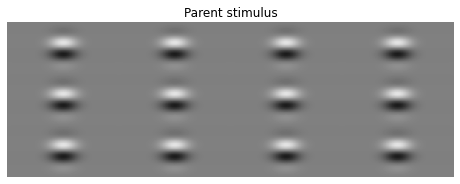

In [5]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(4,3),fixed_freq=0.06)
parent[0,:] = 0.5 *np.pi
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

# Generate child stimuli
children, set_transform = gs.generate_teststim_children(parent,num_child=4,fun_transform=[gs.transform_identity,gs.transform_rotate_left],prob_transform=[0.5,0.5],mode='fixed')

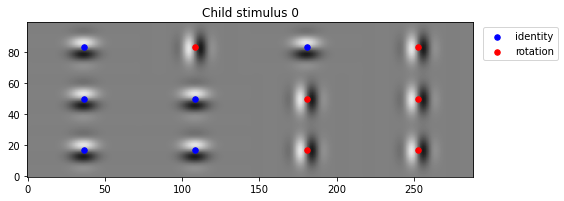

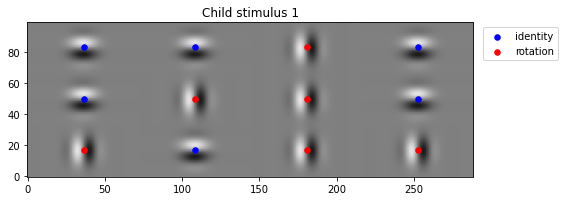

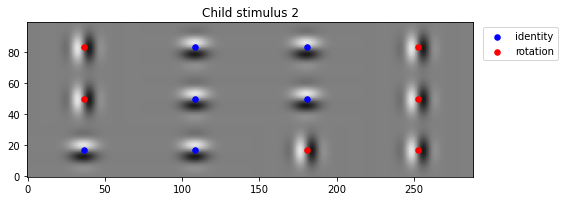

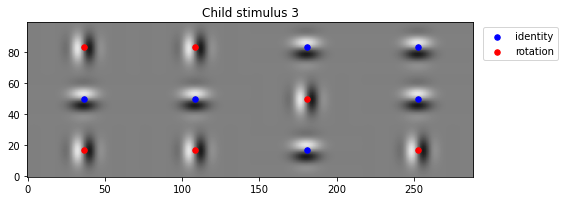

In [16]:
# Plot children 
transform_names = ['identity','rotation']
transform_cols = ['blue','red']

ratio_y_x = (gs.dim_ranges[4][1]-gs.dim_ranges[4][0])/(gs.dim_ranges[5][1]-gs.dim_ranges[5][0])
scale_x = int(np.round(100*ratio_y_x))/260
scale_y = 100/90

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,ratio_y_x*8))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*scale_x
        yloc = (children[i][5,set_transform[i][j]] + 20)*scale_y
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

12
[[1.         0.5        0.66666667 0.5       ]
 [0.5        1.         0.33333333 0.5       ]
 [0.66666667 0.33333333 1.         0.33333333]
 [0.5        0.5        0.33333333 1.        ]]
[0.5        0.66666667 0.5        0.33333333 0.5        0.33333333]


(0.0, 1.0)

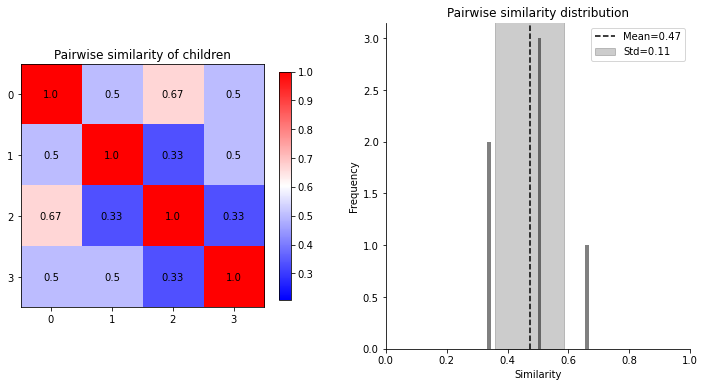

In [17]:
# Compute feature-based pairwise similarity
df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
print(len(df_children[0]))

sim_features = ['orientation']
list_children_features = [df_children[i][sim_features].to_numpy() for i in range(len(df_children))]  

pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([0,1])

[[1.         0.50018478 0.66673925 0.5000468 ]
 [0.50018478 1.         0.33342924 0.50023161]
 [0.66673925 0.33342924 1.         0.33356491]
 [0.5000468  0.50023161 0.33356491 1.        ]]
[0.50018478 0.66673925 0.5000468  0.33342924 0.50023161 0.33356491]


(-1.0, 1.0)

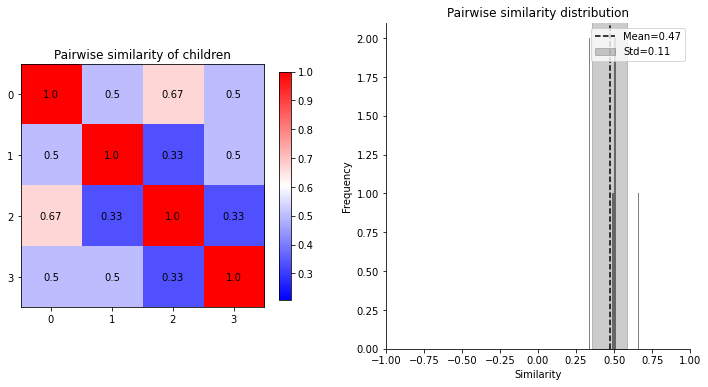

In [18]:
# Compute pixel-based pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot pixel-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

   orientation     phase  frequency     width  x-position  y-position
0     0.000000 -1.570796       0.04  8.333333         0.0         0.0
1     1.570796 -1.570796       0.04  8.333333         0.0         0.0
2     0.000000  1.570796       0.04  8.333333         0.0         0.0
3     1.570796  1.570796       0.04  8.333333         0.0         0.0
(4, 100, 289)
4
(7300,)
[[1.         0.56268388 0.70878888 0.56106722]
 [0.56268388 1.         0.41625461 0.56210925]
 [0.70878888 0.41625461 1.         0.41561954]
 [0.56106722 0.56210925 0.41561954 1.        ]]
[0.56268388 0.70878888 0.56106722 0.41625461 0.56210925 0.41561954]


(-1.0, 1.0)

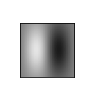

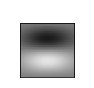

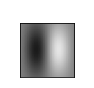

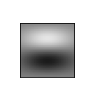

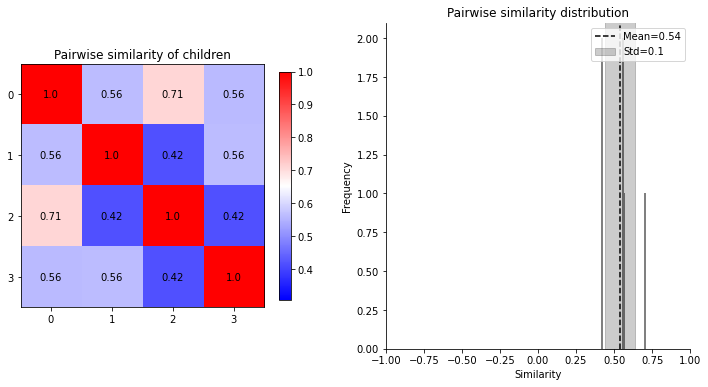

In [19]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=4,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
print(k_params['ref_gabors'])

vec_parent = im_parent[None,:,:]
vec_children = np.stack(im_children)
print(vec_children.shape)

kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
print(len(kernels_children))
print(kernels_children[0].shape)

pairwise_sim = comp_pairwise_sim(kernels_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

# Compute parent-children similarity
# parent_sim = comp_parent_sim(kmat_parent,kernels_children)
# print(f'Kernel-based similarity between child and parent: {parent_sim[0]}')

# f,ax = plt.subplots(1,1+len(parent_sim),figsize=(3*(1+len(parent_sim)),3))
# ax[0].bar(np.arange(kmat_parent.shape[0]),kmat_parent,color='k')
# xlines = [kmat_parent.shape[0]/4*(i+1) for i in range(3)]
# for x in xlines:
#     ax[0].axvline(x=x)
# ax[0].set_title('Parent kernel vector')
# ax[0].set_xlabel('Kernel index')
# ax[0].set_ylabel('Kernel activation')

# for i in range(len(parent_sim)):
#     ax[i+1].bar(np.arange(kmat_children.shape[0]),kmat_children[:,i],color='r')
#     for x in xlines:
#         ax[i+1].axvline(x=x)
#     ax[i+1].set_title('Child kernel vector')
#     ax[i+1].set_xlabel('Kernel index')
#     ax[i+1].set_ylabel('Kernel activation')
# f.tight_layout()

In [ ]:
vec0 = np.array([-1,1,1,-1, 0,0,0,0, 1,-1,-1,1, 0,0,0,0])
vec1 = np.array([0,1,0,-1, 1,0,1,0, 0,-1,0,1, -1,0,-1,0])
vec2 = np.array([-1,1,1,-1, 0,0,0,0, 1,-1,-1,1, 0,0,0,0])
vec3 = np.array([0,0,1,-1, 1,1,0,0, 0,0,-1,1, -1,-1,0,0])

vec = [vec0, vec1, vec2, vec3]
sim = np.zeros((len(vec),len(vec)))
for i in range(len(vec)):
    for j in range(len(vec)):
        sim_ij = cosine_sim(vec[i],vec[j])
        sim[i][j] = sim_ij
    sim[i][i] = 1

sim

array([[1. , 0.5, 1. , 0.5],
       [0.5, 1. , 0.5, 0.5],
       [1. , 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

In [156]:
vecp = [np.heaviside(veci,0) for veci in vec]

simp = np.zeros((len(vecp),len(vecp)))
for i in range(len(vecp)):
    for j in range(len(vecp)):
        sim_ij = cosine_sim(vecp[i],vecp[j])
        simp[i][j] = sim_ij
    simp[i][i] = 1

simp

array([[1. , 0.5, 1. , 0.5],
       [0.5, 1. , 0.5, 0.5],
       [1. , 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Transform-based exact overlap

Successfully generated 4 children.


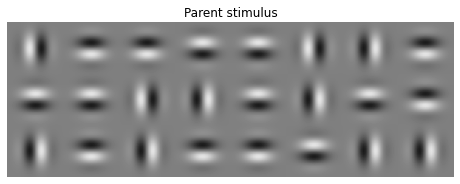

In [18]:
# Generate parent stimulus
parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(8,3),fixed_freq=0.06)
# parent[0,:] = 0.5 *np.pi
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1)

f,ax = plt.subplots(1,1,figsize=(8,16))
ax.imshow(im_parent,cmap='gray',vmin=-1,vmax=1,origin='lower')
ax.axis('off')
ax.set_title('Parent stimulus')

# Generate child stimuli
children, set_transform = gs.generate_teststim_children_exact(parent,num_child=4,fun_transform=[gs.transform_rotate_left],prob_transform=[0.25],mode='fixed') # valid prob: 0.04-0.25 (for four children), 0.04-0.07 (for 13 children)

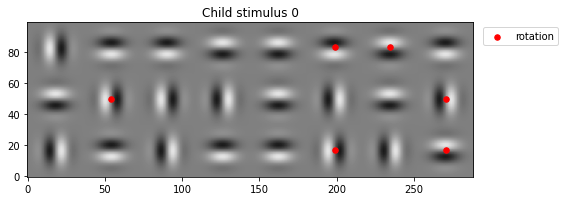

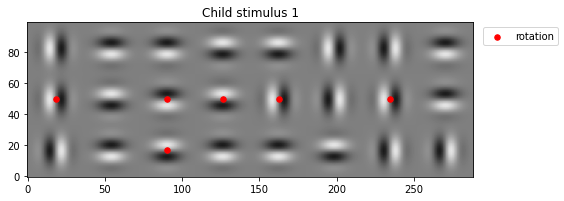

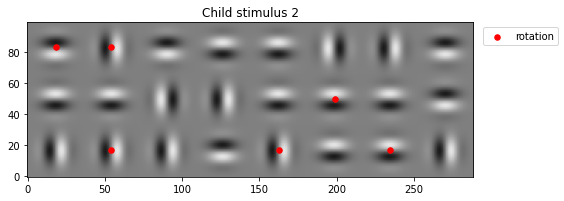

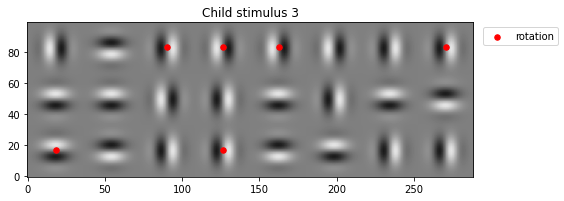

In [19]:
# Plot children 
transform_names = ['rotation']
transform_cols = ['red']

ratio_y_x = (gs.dim_ranges[4][1]-gs.dim_ranges[4][0])/(gs.dim_ranges[5][1]-gs.dim_ranges[5][0])
scale_x = int(np.round(100*ratio_y_x))/260
scale_y = 100/90

im_children = []
for i in range(len(children)):
    # Plot child
    im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[i],resolution=100,magn=1)
    im_children.append(im_child)
    f,ax = plt.subplots(1,1,figsize=(8,ratio_y_x*8))
    ax.imshow(im_child,cmap='gray',vmin=-1,vmax=1,origin='lower')
    # ax.axis('off')
    # Plot type of transform for each Gabor
    for j in range(len(set_transform[i])):
        xloc = (children[i][4,set_transform[i][j]] + 130)*scale_x
        yloc = (children[i][5,set_transform[i][j]] + 20)*scale_y
        ax.scatter(xloc,yloc,s=30,color=transform_cols[j],label=transform_names[j])
    ax.legend(bbox_to_anchor=(1.2,1),loc='upper right')
    ax.set_title(f'Child stimulus {i}')    

24
[[1.  0.5 0.5 0.5]
 [0.5 1.  0.5 0.5]
 [0.5 0.5 1.  0.5]
 [0.5 0.5 0.5 1. ]]
[0.5 0.5 0.5 0.5 0.5 0.5]


(0.0, 1.0)

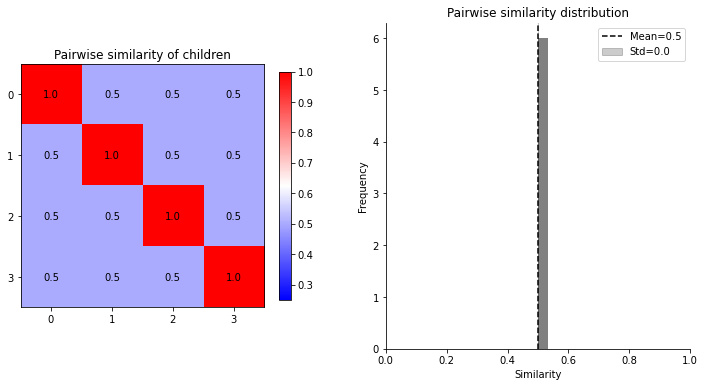

In [20]:
# Compute feature-based pairwise similarity
df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))]  
print(len(df_children[0]))

sim_features = ['orientation']
list_children_features = [df_children[i][sim_features].to_numpy() for i in range(len(df_children))]  

pairwise_sim = comp_pairwise_sim(list_children_features,sim_meas='orientation_sim')
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([0,1])

[[1.         0.50000913 0.49992511 0.499992  ]
 [0.50000913 1.         0.49995851 0.50001075]
 [0.49992511 0.49995851 1.         0.49999299]
 [0.499992   0.50001075 0.49999299 1.        ]]
[0.50000913 0.49992511 0.499992   0.49995851 0.50001075 0.49999299]


(-1.0, 1.0)

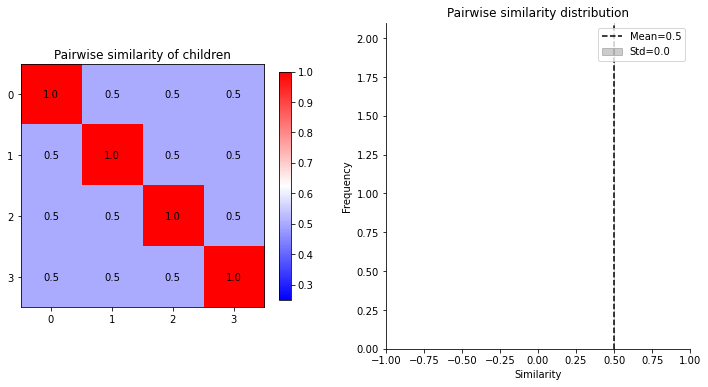

In [21]:
# Compute pixel-based pairwise similarity
pairwise_sim = comp_pairwise_sim(im_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot pixel-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

   orientation     phase  frequency     width  x-position  y-position
0     0.000000 -1.570796       0.04  8.333333         0.0         0.0
1     1.570796 -1.570796       0.04  8.333333         0.0         0.0
2     0.000000  1.570796       0.04  8.333333         0.0         0.0
3     1.570796  1.570796       0.04  8.333333         0.0         0.0
(4, 100, 289)
4
(7300,)
[[1.         0.56297522 0.56237749 0.56291857]
 [0.56297522 1.         0.56002385 0.56368055]
 [0.56237749 0.56002385 1.         0.56177862]
 [0.56291857 0.56368055 0.56177862 1.        ]]
[0.56297522 0.56237749 0.56291857 0.56002385 0.56368055 0.56177862]


(-1.0, 1.0)

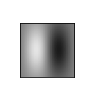

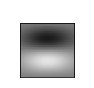

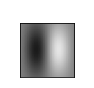

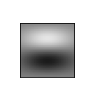

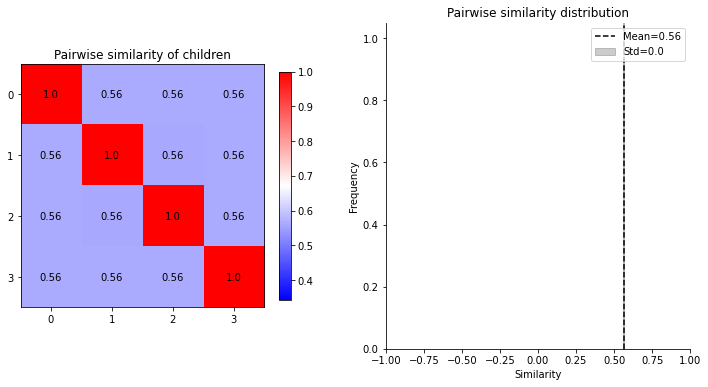

In [22]:
# Create simple cell kernel novelty model
k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=4,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=True)
print(k_params['ref_gabors'])

vec_parent = im_parent[None,:,:]
vec_children = np.stack(im_children)
print(vec_children.shape)

kmat_parent = compute_kernel_matrix((vec_parent,None),k_params,idx=True,conv=True,parallel_k=False).flatten()
kmat_children = compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]
print(len(kernels_children))
print(kernels_children[0].shape)

pairwise_sim = comp_pairwise_sim(kernels_children)
print(pairwise_sim)
pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
print(pairwise_sim_hist)

# Plot feature-based pairwise similarity
f,ax = plt.subplots(1,2,figsize=(12,6))
plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
ax[1].set_xlim([-1,1])

# Compute parent-children similarity
# parent_sim = comp_parent_sim(kmat_parent,kernels_children)
# print(f'Kernel-based similarity between child and parent: {parent_sim[0]}')

# f,ax = plt.subplots(1,1+len(parent_sim),figsize=(3*(1+len(parent_sim)),3))
# ax[0].bar(np.arange(kmat_parent.shape[0]),kmat_parent,color='k')
# xlines = [kmat_parent.shape[0]/4*(i+1) for i in range(3)]
# for x in xlines:
#     ax[0].axvline(x=x)
# ax[0].set_title('Parent kernel vector')
# ax[0].set_xlabel('Kernel index')
# ax[0].set_ylabel('Kernel activation')

# for i in range(len(parent_sim)):
#     ax[i+1].bar(np.arange(kmat_children.shape[0]),kmat_children[:,i],color='r')
#     for x in xlines:
#         ax[i+1].axvline(x=x)
#     ax[i+1].set_title('Child kernel vector')
#     ax[i+1].set_xlabel('Kernel index')
#     ax[i+1].set_ylabel('Kernel activation')
# f.tight_layout()